In [1]:
import numpy as np
import xarray as xr
import os
import fnmatch
from tqdm.autonotebook import tqdm
import dask
import sys
sys.path.insert(0, '/home/jovyan/CMIP6cf/cmip6cf/')
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt

/tmp/ipykernel_1868/3363248783.py:5: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


Load output:

in_dir = '/home/jovyan/CMIP6cf/output/dependence/sfcWind_pr_europe/40yr_p98_lag0d_declus1d/'
output_files = []
for root, dirs, files in os.walk(in_dir, topdown=False):
    for name in files:
        output_files.append(os.path.join(root, name))
ssps = ['ssp245','ssp585']
for s,ssp in enumerate(ssps):
    ssp_ds = xr.open_mfdataset(fnmatch.filter(output_files,'*'+ssp+'*'),concat_dim='source_id',combine='nested',coords='minimal',compat='override',join='outer')
    ssp_ds = ssp_ds.assign_coords({'source_id':[s.split('/')[8] for s in fnmatch.filter(output_files,'*'+ssp+'*')]})
    if s==0:
        ds = ssp_ds
    else:
        ds = xr.concat((ds,ssp_ds),dim='ssp',coords='minimal',compat='override',join='outer')
ds = ds.assign_coords({'ssp':ssps})

#04-05-23
compl = ds['complete_window'].copy(deep=True)

load 0d lag:

In [2]:
in_dir = '/home/jovyan/CMIP6cf/output/dependence/sfcWind_pr_tgs/40yr_p98_lag0d_declus1d_ref2000/'
output_files = []
ssps = ['ssp245','ssp585']

source_ids = [k for k in os.listdir(in_dir) if ~k.startswith('.')]

for s,ssp in enumerate(ssps):
    models = []
    for so,source_id in enumerate(source_ids): #loop over models
        model_path = os.path.join(in_dir,source_id)
        model_ssp_ds = {}

        files = [os.path.join(model_path,f) for f in os.listdir(model_path) if ssp in f]
        if len(files)>0:
            model_ds = xr.open_mfdataset(files,concat_dim='member_id',combine='nested',coords='minimal',compat='override',join='outer').chunk(member_id=100)
            models.append(source_id)
        else:
            continue

        if so==0:
            ssp_ds = model_ds
        else:
            ssp_ds = xr.concat((ssp_ds,model_ds),dim='source_id',coords='minimal',join='outer',compat='override')
            
    ssp_ds = ssp_ds.assign_coords({'source_id':models})   
    
    
    if s==0:
        ds = ssp_ds
    else:
        ds = xr.concat((ds,ssp_ds),dim='ssp')
ds = ds.assign_coords({'ssp':ssps})
ds = ds[['num_co_occurring','num_pr_peaks','num_sfcWind_peaks','complete_window','num_co_occurring_pr_driven','num_co_occurring_sfcWind_driven','num_co_occurring_both_driven']]

Compute slopes change/window:

In [3]:
complete = ds.complete_window.sel(window=slice(1850,2100)).sum(dim='window')==len(ds.complete_window.sel(window=slice(1850,2100)).window)
ds = ds.where(complete) #require runs to be complete from 1970 to 2100

ds = ds.sel(window=slice(1980,2100))
timesteps = xr.DataArray(data=np.arange(len(ds.window)),dims=['window'],coords=dict(window=ds.window))

ds_intersect = ds.where(np.isfinite(ds.complete_window.isel(window=-1)).all(dim=['ssp','tg']))
ds_wind = ds_intersect.load()

load 2d lag:

In [4]:
in_dir = '/home/jovyan/CMIP6cf/output/dependence/surge_pr_tgs/40yr_p98_lag0d_declus1d_ref2000/'
output_files = []
ssps = ['ssp245','ssp585']

source_ids = [k for k in os.listdir(in_dir) if ~k.startswith('.')]

for s,ssp in enumerate(ssps):
    models = []
    for so,source_id in enumerate(source_ids): #loop over models
        model_path = os.path.join(in_dir,source_id)
        model_ssp_ds = {}

        files = [os.path.join(model_path,f) for f in os.listdir(model_path) if ssp in f]
        if len(files)>0:
            model_ds = xr.open_mfdataset(files,concat_dim='member_id',combine='nested',coords='minimal',compat='override',join='outer').chunk(member_id=100)
            models.append(source_id)
        else:
            continue

        if so==0:
            ssp_ds = model_ds
        else:
            ssp_ds = xr.concat((ssp_ds,model_ds),dim='source_id',coords='minimal',join='outer',compat='override')
            
    ssp_ds = ssp_ds.assign_coords({'source_id':models})   
    
    
    if s==0:
        ds = ssp_ds
    else:
        ds = xr.concat((ds,ssp_ds),dim='ssp')
ds = ds.assign_coords({'ssp':ssps})
ds = ds[['num_co_occurring','num_pr_peaks','num_surge_peaks','complete_window','num_co_occurring_pr_driven','num_co_occurring_surge_driven','num_co_occurring_both_driven']]

In [5]:
complete = ds.complete_window.sel(window=slice(1850,2100)).sum(dim='window')==len(ds.complete_window.sel(window=slice(1850,2100)).window)
ds = ds.where(complete) #require runs to be complete from 1970 to 2100

ds = ds.sel(window=slice(1980,2100))
timesteps = xr.DataArray(data=np.arange(len(ds.window)),dims=['window'],coords=dict(window=ds.window))

ds_intersect = ds.where(np.isfinite(ds.complete_window.isel(window=-1)).all(dim=['ssp','tg']))
ds_surge = ds_intersect.load()

Using all data per ssp:

/srv/conda/envs/notebook/lib/python3.10/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


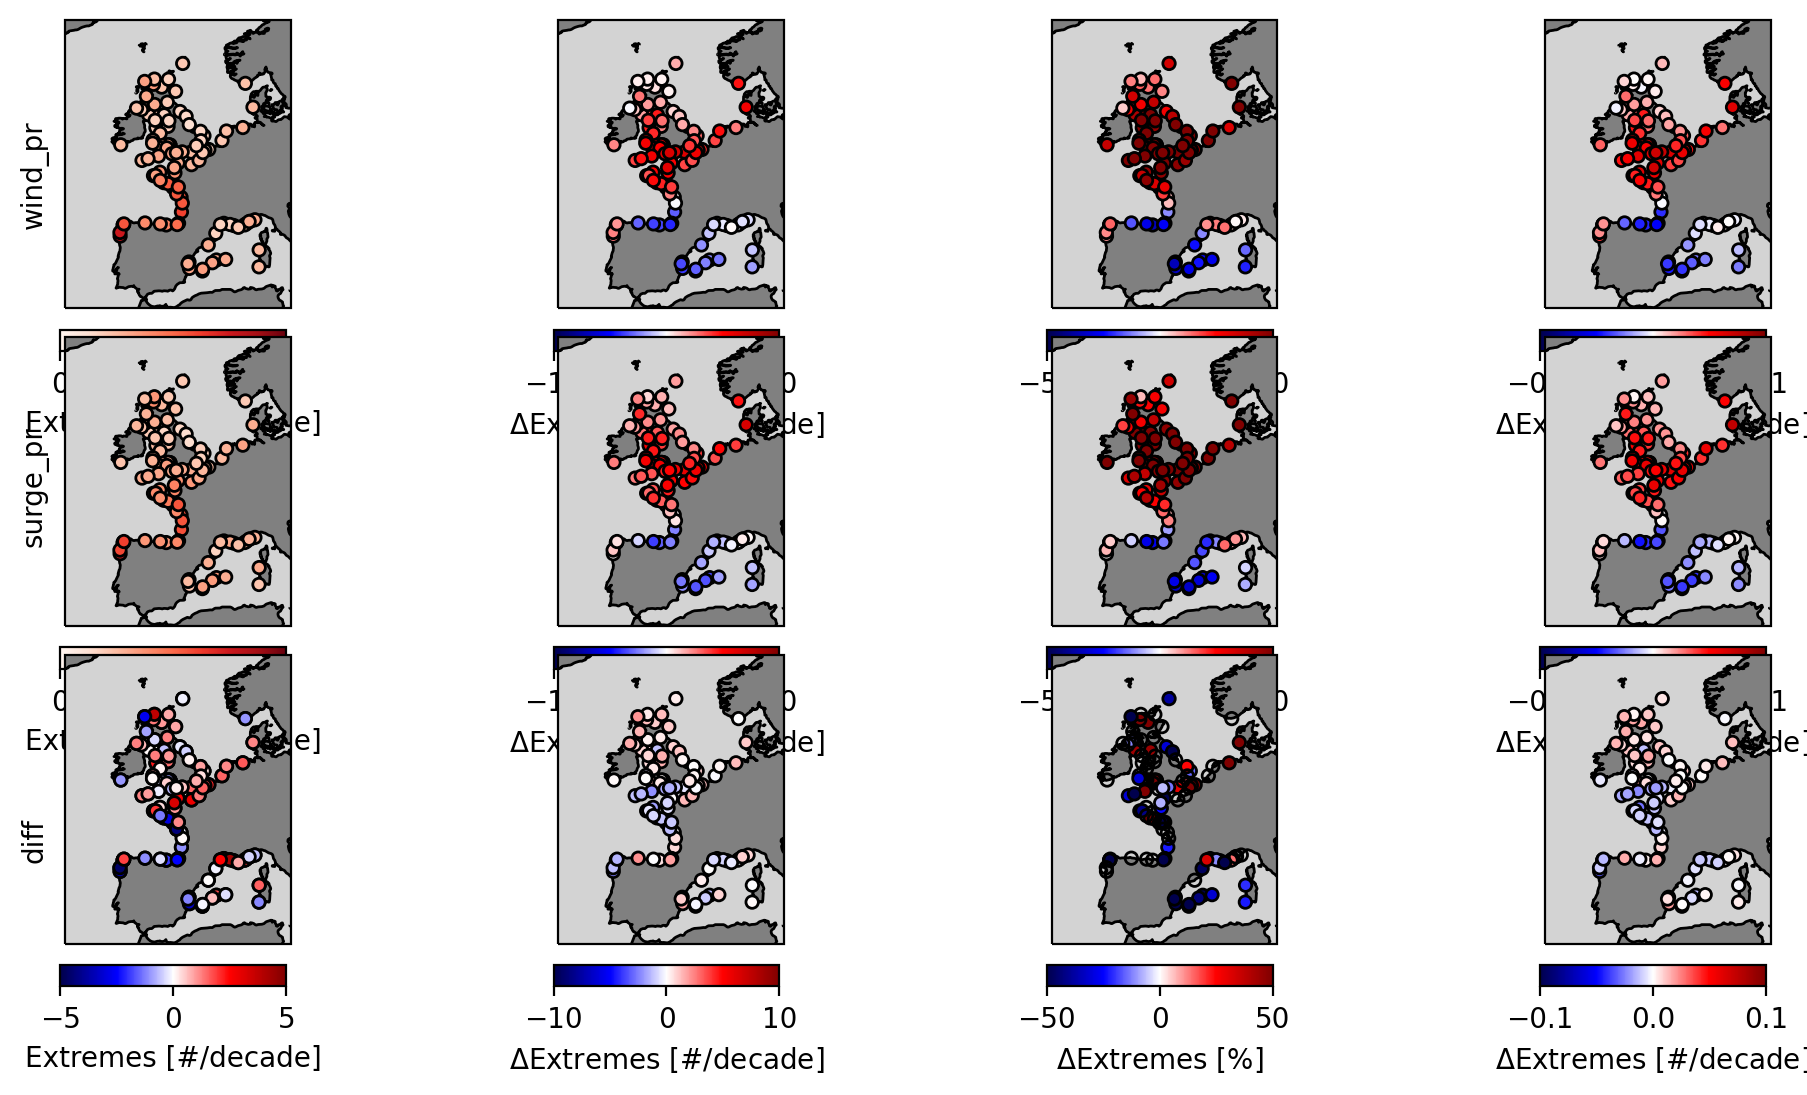

In [18]:
fig=plt.figure(figsize=(15,6)) #generate figure  
gs = fig.add_gridspec(3,5)
gs.update(wspace=.4,hspace=.1)

ssp = 'ssp585'
for v in np.array([0,1,2]):
    if v==0:
        ssp_ds = ds_wind.sel(ssp=ssp).sum(dim='month',skipna=False)
    elif v==1:
        ssp_ds = ds_surge.sel(ssp=ssp).sum(dim='month',skipna=False)
    elif v==2:
        ssp_ds = ds_surge.sel(ssp=ssp).sum(dim='month',skipna=False) - ds_wind.sel(ssp=ssp).sum(dim='month',skipna=False)
    #ssp_ds = ds_intersect.sel(ssp=ssp).isel(month=-1) + ds_intersect.sel(ssp=ssp).isel(month=0) + ds_intersect.sel(ssp=ssp).isel(month=1) 
    ssp_ds_present = ssp_ds.sel(window=2000)#.sel(window=2005)
    ssp_ds_future = ssp_ds.sel(window=2080)#.sel(window=2085)
    ssp_ds_diff = ssp_ds_future - ssp_ds_present

    #1991-2020
    ax = plt.subplot(gs[v,0],projection=ccrs.Robinson(central_longitude=0))

    ax.add_feature(cartopy.feature.OCEAN, zorder=0,facecolor='lightgrey')
    ax.add_feature(cartopy.feature.LAND, zorder=0, facecolor='grey')

    sc=ax.scatter(ssp_ds.lon,ssp_ds.lat,c=(.25*ssp_ds_present.num_co_occurring.mean(dim='member_id').mean(dim='source_id')),cmap='Reds',vmin=0,vmax=30,s=20,transform=ccrs.PlateCarree(),zorder=3,edgecolor='black')
    if v==2:
         sc=ax.scatter(ssp_ds.lon,ssp_ds.lat,c=(.25*ssp_ds_present.num_co_occurring.mean(dim='member_id').mean(dim='source_id')),cmap='seismic',vmin=-5,vmax=5,s=20,transform=ccrs.PlateCarree(),zorder=3,edgecolor='black')
    #sc=(.25*ssp_ds_present.num_co_occurring.mean(dim='member_id').mean(dim='source_id')).plot.scatter(cmap='Reds',vmin=0,vmax=30,transform=ccrs.PlateCarree(),zorder=3,ax=ax,add_colorbar=False)
    ax.coastlines(zorder=1)
    #sc=ax.scatter(ssp_ds.lon,ssp_ds.lat,c=.25*ssp_ds_present.num_co_occurring.mean(dim='member_id').mean(dim='source_id'),cmap='Reds',vmin=0,vmax=30,s=20,transform=ccrs.PlateCarree(),zorder=3)
    ax.set_extent([-15, 12, 35, 65], crs=ccrs.PlateCarree())

    if s==1:
        cax=inset_axes(ax,width="100%", height="100%",bbox_to_anchor=(0.04, -.1,1,.075),bbox_transform=ax.transAxes)
        cb=fig.colorbar(sc, cax=cax,orientation='horizontal',label='Extremes [#/decade]')
        ax.set_title('')
    if s==0:
        ax.set_title('1981-2020')

    ax.annotate(['wind_pr','surge_pr','diff'][v],(-.2,.3),xycoords='axes fraction',rotation=90)
    #ax.annotate('ad'[v]+')',(.05,.9),xycoords='axes fraction',fontweight='bold')
      
    ax = plt.subplot(gs[v,1],projection=ccrs.Robinson(central_longitude=0))

    ax.add_feature(cartopy.feature.OCEAN, zorder=0,facecolor='lightgrey')
    ax.add_feature(cartopy.feature.LAND, zorder=0, facecolor='grey')

    '''
    diff = ssp_ds_diff.num_co_occurring.mean(dim='member_id')
    ens_diff = ssp_ds_diff.num_co_occurring.mean(dim='member_id').mean(dim='source_id')

    num_agree = ((diff*ens_diff)>0).sum(dim='source_id')
    fraction_exceeds = (num_agree>=.75*len(diff.source_id))
    '''    
    #sc=ax.scatter(ssp_ds.lon[~fraction_exceeds],ssp_ds.lat[~fraction_exceeds],c=.25*ssp_ds_diff.num_co_occurring.mean(dim='member_id').mean(dim='source_id')[~fraction_exceeds],cmap='seismic',vmin=-10,vmax=10,s=20,transform=ccrs.PlateCarree(),zorder=3)
    #sc=ax.scatter(ssp_ds.lon[fraction_exceeds],ssp_ds.lat[fraction_exceeds],c=.25*ssp_ds_diff.num_co_occurring.mean(dim='member_id').mean(dim='source_id')[fraction_exceeds],cmap='seismic',vmin=-10,vmax=10,s=20,edgecolor='black',transform=ccrs.PlateCarree(),zorder=3,label='$\geq$75% agree')
    sc=ax.scatter(ssp_ds.lon,ssp_ds.lat,c=(.25*ssp_ds_diff.num_co_occurring.mean(dim='member_id').mean(dim='source_id')),cmap='seismic',vmin=-10,vmax=10,s=20,transform=ccrs.PlateCarree(),zorder=3,edgecolor='black')
    #sc=(.25*ssp_ds_diff.num_co_occurring.mean(dim='member_id').mean(dim='source_id')).plot(cmap='seismic',vmin=-10,vmax=10,transform=ccrs.PlateCarree(),zorder=3,ax=ax,add_colorbar=False)
    ax.coastlines(zorder=1)
    ax.set_extent([-15, 12, 35, 65], crs=ccrs.PlateCarree())

    if s==0:
        ax.legend(ncols=1,markerscale=1,loc=(.1,-.05),frameon=True)
        ax.set_title('Projected change')
    if s==1:
        ax.set_title('')
        cax=inset_axes(ax,width="100%", height="100%",bbox_to_anchor=(0.04, -.1,1,.075),bbox_transform=ax.transAxes)
        cb=fig.colorbar(sc, cax=cax,orientation='horizontal',label='$\Delta$Extremes [#/decade]')
    #ax.annotate('be'[v]+')',(.05,.9),xycoords='axes fraction',fontweight='bold')    
       
    ax = plt.subplot(gs[v,2],projection=ccrs.Robinson(central_longitude=0))

    ax.add_feature(cartopy.feature.OCEAN, zorder=0,facecolor='lightgrey')
    ax.add_feature(cartopy.feature.LAND, zorder=0, facecolor='grey')

    sc=ax.scatter(ssp_ds.lon,ssp_ds.lat,c=(100*ssp_ds_diff.num_co_occurring/ssp_ds_present.num_co_occurring).mean(dim='member_id').mean(dim='source_id'),cmap='seismic',vmin=-50,vmax=50,s=20,transform=ccrs.PlateCarree(),zorder=3,edgecolor='black')
    ax.coastlines(zorder=1)
    ax.set_extent([-15, 12, 35, 65], crs=ccrs.PlateCarree())

    if s==1:
        cax=inset_axes(ax,width="100%", height="100%",bbox_to_anchor=(0.04, -.1,1,.075),bbox_transform=ax.transAxes)
        cb=fig.colorbar(sc, cax=cax,orientation='horizontal',label='$\Delta$Extremes [%]')
        ax.set_title('')
    if s==0:
        ax.set_title('% change')
    #ax.annotate('cf'[v]+')',(.05,.9),xycoords='axes fraction',fontweight='bold')
#meaning of number of joint extremes?

#fig.savefig('Figures/ensmean_num_joint_extremes_knmi.pdf',format='pdf',dpi=300,bbox_inches='tight')


    
    ax = plt.subplot(gs[v,3],projection=ccrs.Robinson(central_longitude=0))

    ax.add_feature(cartopy.feature.OCEAN, zorder=0,facecolor='lightgrey')
    ax.add_feature(cartopy.feature.LAND, zorder=0, facecolor='grey')

    
    slope = (1/np.diff(ds.window)[0])*xr.corr(ssp_ds.num_co_occurring,timesteps,dim='window')*ssp_ds.num_co_occurring.std(dim='window')/timesteps.std(dim='window')
    
    sc=ax.scatter(ssp_ds.lon,ssp_ds.lat,c=(.25*slope.mean(dim='member_id').mean(dim='source_id')),cmap='seismic',vmin=-.1,vmax=.1,s=20,transform=ccrs.PlateCarree(),zorder=3,edgecolor='black')
    
    #sc=(.25*slope.mean(dim='member_id').mean(dim='source_id')).plot(cmap='seismic',vmin=-.1,vmax=.1,transform=ccrs.PlateCarree(),zorder=3,add_colorbar=False)
    ax.coastlines(zorder=1)    
    ax.set_extent([-15, 12, 35, 65], crs=ccrs.PlateCarree())

    if s==0:
        ax.legend(ncols=1,markerscale=1,loc=(.1,-.05),frameon=True)
        ax.set_title('slope joint')
    if s==1:
        ax.set_title('')
        cax=inset_axes(ax,width="100%", height="100%",bbox_to_anchor=(0.04, -.1,1,.075),bbox_transform=ax.transAxes)
        cb=fig.colorbar(sc, cax=cax,orientation='horizontal',label='$\Delta$Extremes [#/decade]')
    #ax.annotate('be'[v]+')',(.05,.9),xycoords='axes fraction',fontweight='bold')    
    '''
    ax = plt.subplot(gs[v,4],projection=ccrs.Robinson(central_longitude=0))

    ax.add_feature(cartopy.feature.OCEAN, zorder=0,facecolor='lightgrey')
    ax.add_feature(cartopy.feature.LAND, zorder=0, facecolor='grey')

    
    
    sc=(.25*ssp_ds_diff.num_co_occurring.mean(dim='member_id').std(dim='source_id')).plot(cmap='Reds',vmin=0,vmax=7,transform=ccrs.PlateCarree(),zorder=3,add_colorbar=False)
    ax.coastlines(zorder=5)    
    #ax.set_extent([-15, 12, 35, 65], crs=ccrs.PlateCarree())

    if s==0:
        ax.legend(ncols=1,markerscale=1,loc=(.1,-.05),frameon=True)
        ax.set_title('1 std')
    if s==1:
        ax.set_title('')
        cax=inset_axes(ax,width="100%", height="100%",bbox_to_anchor=(0.04, -.1,1,.075),bbox_transform=ax.transAxes)
        cb=fig.colorbar(sc, cax=cax,orientation='horizontal',label='$\Delta$Extremes [#/decade]')
    #ax.annotate('be'[v]+')',(.05,.9),xycoords='axes fraction',fontweight='bold')    
    
    
    
    '''
    

Decomposition:

'\nax = plt.subplot(gs[1,0],projection=ccrs.Robinson(central_longitude=0))\n\nsc = (.25*(mri_dependence.sel(member_id=\'r1i1p1f1\',window=2080).num_co_occurring.sum(dim=\'month\',skipna=False)-mri_dependence.sel(member_id=\'r1i1p1f1\',window=1980).num_co_occurring.sum(dim=\'month\',skipna=False))).plot(ax=ax,transform=ccrs.PlateCarree(),vmin=-10,vmax=10,cmap=\'seismic\',add_colorbar=False)\nax.coastlines(zorder=2)\n\ncax=inset_axes(ax,width="100%", height="100%",bbox_to_anchor=(0.04, -.1,1,.075),bbox_transform=ax.transAxes)\ncb=fig.colorbar(sc, cax=cax,orientation=\'horizontal\',label=\'$\\Delta$Co-oc extremes [#/decade]\')\nax.set_title(\'total change (recomputing 98%)\')   \n\n\nax = plt.subplot(gs[1,1],projection=ccrs.Robinson(central_longitude=0))\n\nsc = (.25*(num_co_occurring.mean(dim=\'member_id\').sel(window=2080)-mri_dependence.sel(member_id=\'r1i1p1f1\',window=2080).num_co_occurring.sum(dim=\'month\',skipna=False))).plot(ax=ax,transform=ccrs.PlateCarree(),vmin=-10,vmax=10,cma

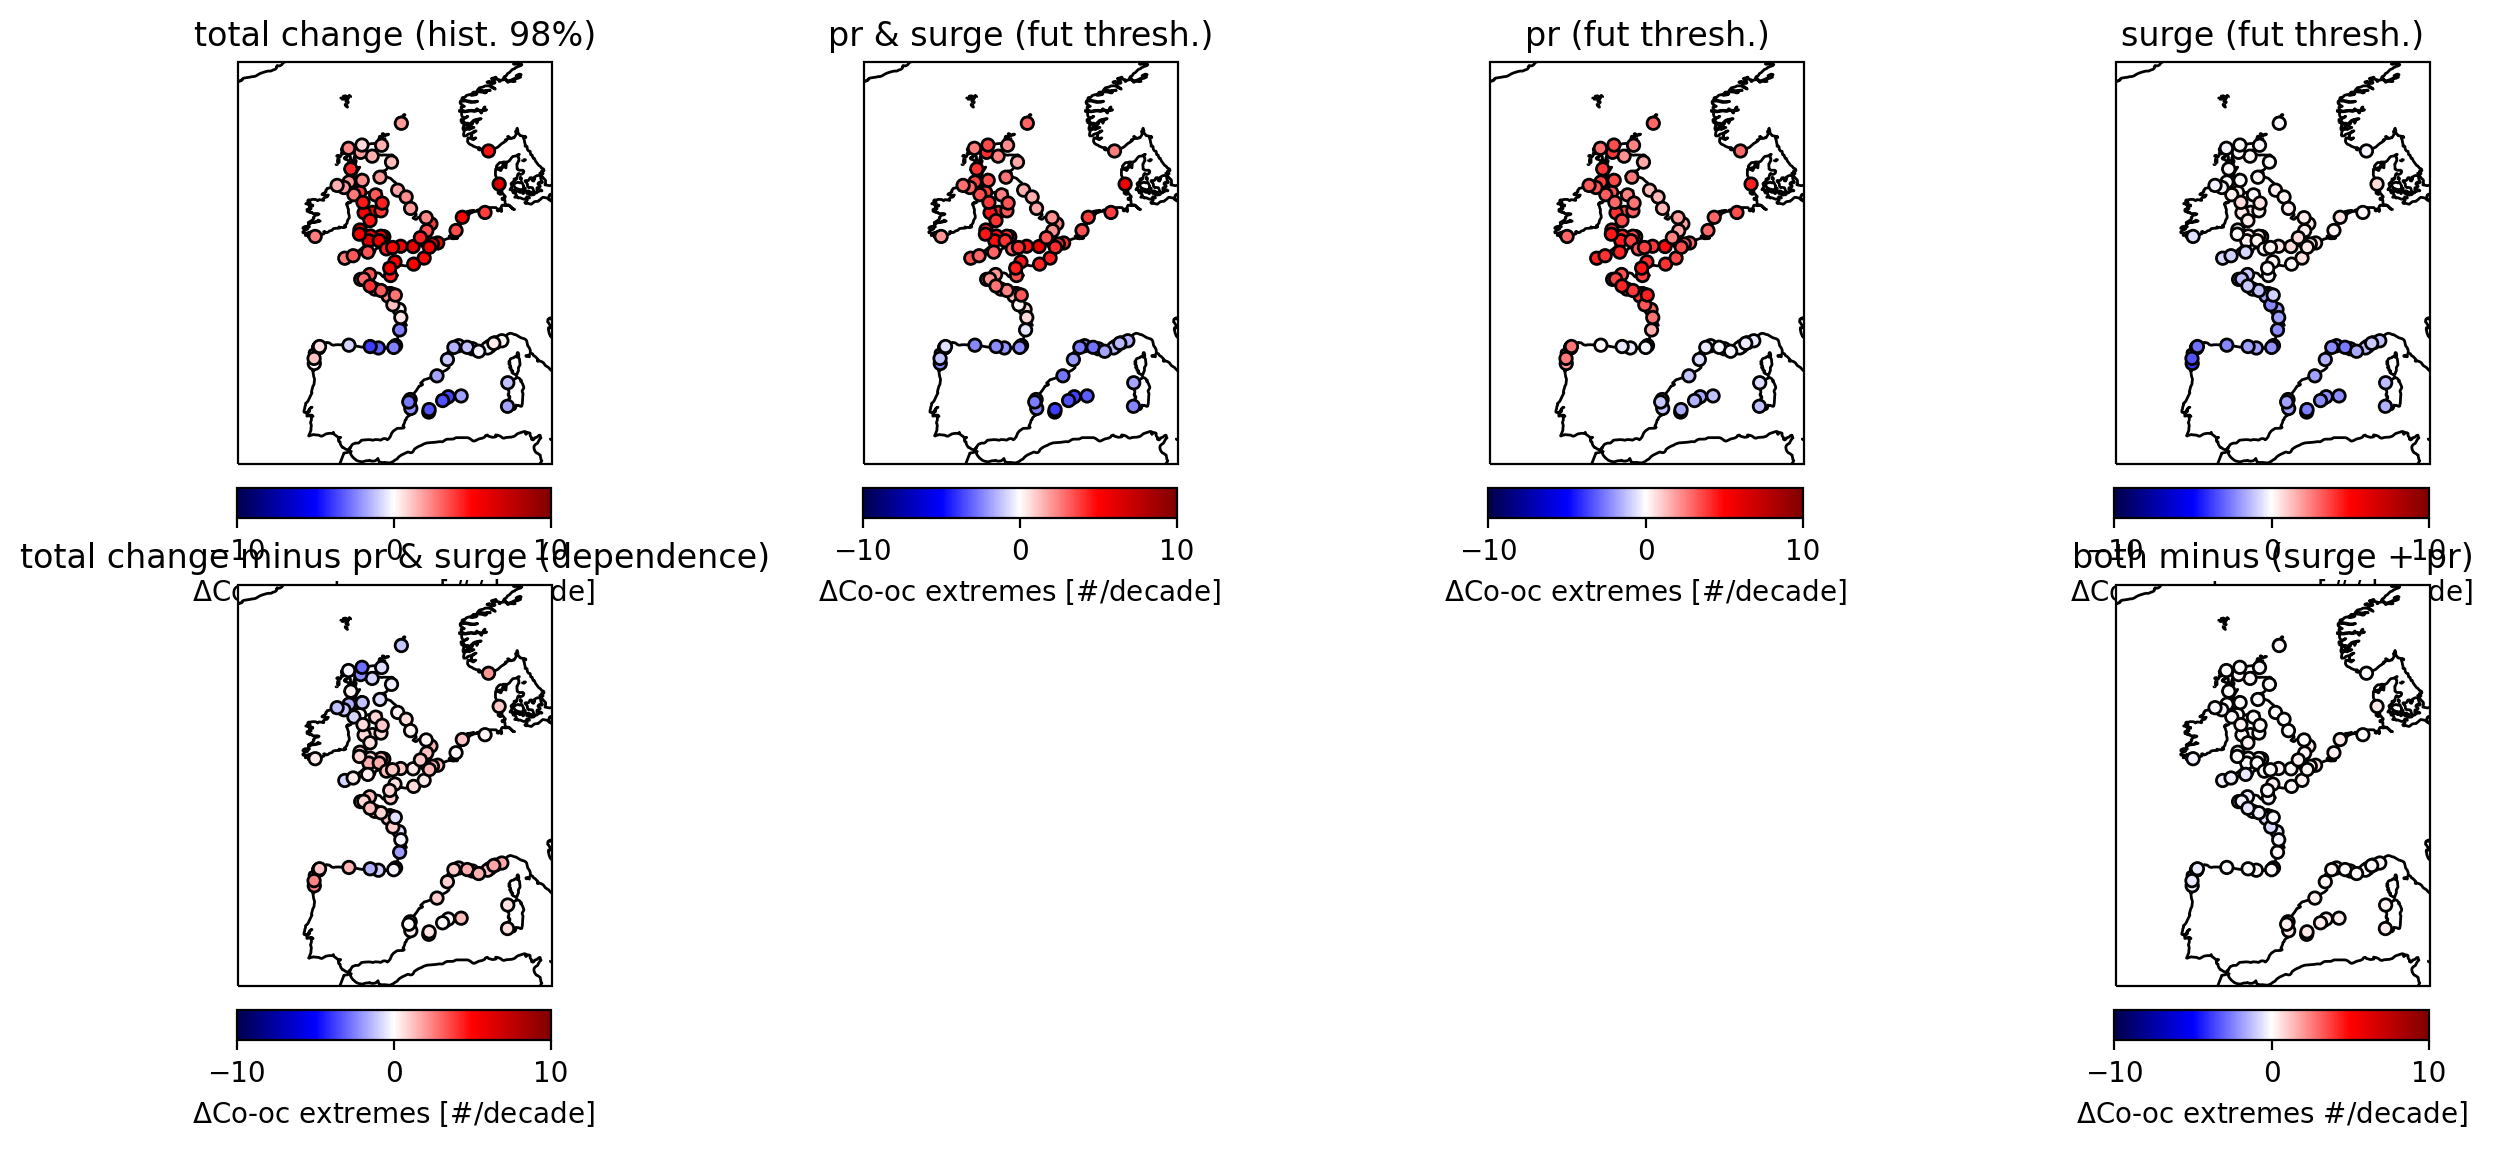

In [22]:
fig=plt.figure(figsize=(15,6)) #generate figure  
gs = fig.add_gridspec(2,4)
gs.update(wspace=.4,hspace=.3)

ssp='ssp585'
ssp_ds = ds_surge.sel(ssp=ssp).sum(dim='month',skipna=False)
#ssp_ds = ds_intersect.sel(ssp=ssp).sum(dim='month',skipna=False)
#ssp_ds = ds_intersect.sel(ssp=ssp).isel(month=-1) + ds_intersect.sel(ssp=ssp).isel(month=0) + ds_intersect.sel(ssp=ssp).isel(month=1) 
ssp_ds_present = ssp_ds.sel(window=2000)#.sel(window=2005)
ssp_ds_future = ssp_ds.sel(window=2080)#.sel(window=2085)
ssp_ds_diff = ssp_ds_future - ssp_ds_present

    
#1991-2020
ax = plt.subplot(gs[0,0],projection=ccrs.Robinson(central_longitude=0))

sc=ax.scatter(ssp_ds.lon,ssp_ds.lat,c=(.25*ssp_ds_diff.num_co_occurring.mean(dim='member_id').mean(dim='source_id')),cmap='seismic',vmin=-10,vmax=10,s=20,transform=ccrs.PlateCarree(),zorder=3,edgecolor='black')
#sc = (.25*ssp_ds_diff.num_co_occurring.mean(dim='member_id').mean(dim='source_id')).plot(ax=ax,transform=ccrs.PlateCarree(),vmin=-10,vmax=10,cmap='seismic',add_colorbar=False)

ax.coastlines(zorder=1)
ax.set_extent([-15, 12, 35, 65], crs=ccrs.PlateCarree())

cax=inset_axes(ax,width="100%", height="100%",bbox_to_anchor=(0.04, -.1,1,.075),bbox_transform=ax.transAxes)
cb=fig.colorbar(sc, cax=cax,orientation='horizontal',label='$\Delta$Co-oc extremes [#/decade]')
ax.set_title('total change (hist. 98%)')


ax = plt.subplot(gs[0,1],projection=ccrs.Robinson(central_longitude=0))

both_driven = (ssp_ds.num_co_occurring_both_driven-ssp_ds_present.num_co_occurring)

sc=ax.scatter(ssp_ds.lon,ssp_ds.lat,c=(.25*both_driven.mean(dim='member_id').mean(dim='source_id')),cmap='seismic',vmin=-10,vmax=10,s=20,transform=ccrs.PlateCarree(),zorder=3,edgecolor='black')
#sc = (.25*both_driven.mean(dim='member_id').mean(dim='source_id')).plot(ax=ax,transform=ccrs.PlateCarree(),vmin=-10,vmax=10,cmap='seismic',add_colorbar=False)

ax.coastlines(zorder=1)
ax.set_extent([-15, 12, 35, 65], crs=ccrs.PlateCarree())

cax=inset_axes(ax,width="100%", height="100%",bbox_to_anchor=(0.04, -.1,1,.075),bbox_transform=ax.transAxes)
cb=fig.colorbar(sc, cax=cax,orientation='horizontal',label='$\Delta$Co-oc extremes [#/decade]')
ax.set_title('pr & surge (fut thresh.)')

ax = plt.subplot(gs[0,2],projection=ccrs.Robinson(central_longitude=0))

pr_driven = (ssp_ds.num_co_occurring_pr_driven-ssp_ds_present.num_co_occurring)

sc=ax.scatter(ssp_ds.lon,ssp_ds.lat,c=(.25*pr_driven.mean(dim='member_id').mean(dim='source_id')),cmap='seismic',vmin=-10,vmax=10,s=20,transform=ccrs.PlateCarree(),zorder=3,edgecolor='black')
#sc = (.25*pr_driven.mean(dim='member_id').mean(dim='source_id')).plot(ax=ax,transform=ccrs.PlateCarree(),vmin=-10,vmax=10,cmap='seismic',add_colorbar=False)

ax.coastlines(zorder=1)
ax.set_extent([-15, 12, 35, 65], crs=ccrs.PlateCarree())
cax=inset_axes(ax,width="100%", height="100%",bbox_to_anchor=(0.04, -.1,1,.075),bbox_transform=ax.transAxes)
cb=fig.colorbar(sc, cax=cax,orientation='horizontal',label='$\Delta$Co-oc extremes [#/decade]')
ax.set_title('pr (fut thresh.)')


ax = plt.subplot(gs[0,3],projection=ccrs.Robinson(central_longitude=0))

sfcWind_driven = (ssp_ds.num_co_occurring_surge_driven-ssp_ds_present.num_co_occurring)

sc=ax.scatter(ssp_ds.lon,ssp_ds.lat,c=(.25*sfcWind_driven.mean(dim='member_id').mean(dim='source_id')),cmap='seismic',vmin=-10,vmax=10,s=20,transform=ccrs.PlateCarree(),zorder=3,edgecolor='black')
#sc = (.25*sfcWind_driven.mean(dim='member_id').mean(dim='source_id')).plot(ax=ax,transform=ccrs.PlateCarree(),vmin=-10,vmax=10,cmap='seismic',add_colorbar=False)

ax.coastlines(zorder=1)
ax.set_extent([-15, 12, 35, 65], crs=ccrs.PlateCarree())

cax=inset_axes(ax,width="100%", height="100%",bbox_to_anchor=(0.04, -.1,1,.075),bbox_transform=ax.transAxes)
cb=fig.colorbar(sc, cax=cax,orientation='horizontal',label='$\Delta$Co-oc extremes [#/decade]')
ax.set_title('surge (fut thresh.)')    


#sc=ax.scatter(sfcWind_peaks_hist.lon,sfcWind_peaks_hist.lat,c=sfcWind_peaks_hist.has_track.sum(dim='time')/np.isfinite(sfcWind_peaks_hist.sfcWind).sum(dim='time'),cmap='Reds',vmin=0,vmax=.8,s=20,transform=ccrs.PlateCarree(),zorder=3)
#ax.set_extent([-15, 12, 35, 65], crs=ccrs.PlateCarree())

#cax=inset_axes(ax,width="100%", height="100%",bbox_to_anchor=(1.1, 0.035,.075,1),bbox_transform=ax.transAxes)
#cb=fig.colorbar(sc, cax=cax,orientation='vertical',label='Fraction etcs/extremes [-]')

ax = plt.subplot(gs[1,3],projection=ccrs.Robinson(central_longitude=0))

sc=ax.scatter(ssp_ds.lon,ssp_ds.lat,c=(.25*(both_driven-(sfcWind_driven+pr_driven)).mean(dim='member_id').mean(dim='source_id')),cmap='seismic',vmin=-10,vmax=10,s=20,transform=ccrs.PlateCarree(),zorder=3,edgecolor='black')
#sc = (.25*(both_driven-(sfcWind_driven+pr_driven)).mean(dim='member_id').mean(dim='source_id')).plot(ax=ax,transform=ccrs.PlateCarree(),vmin=-10,vmax=10,cmap='seismic',add_colorbar=False)

ax.coastlines(zorder=1)
ax.set_extent([-15, 12, 35, 65], crs=ccrs.PlateCarree())

cax=inset_axes(ax,width="100%", height="100%",bbox_to_anchor=(0.04, -.1,1,.075),bbox_transform=ax.transAxes)
cb=fig.colorbar(sc, cax=cax,orientation='horizontal',label='$\Delta$Co-oc extremes #/decade]')
ax.set_title('both minus (surge + pr)')   

dependence_driven = (ssp_ds_future.num_co_occurring-ssp_ds.num_co_occurring_both_driven)

ax = plt.subplot(gs[1,0],projection=ccrs.Robinson(central_longitude=0))

sc=ax.scatter(ssp_ds.lon,ssp_ds.lat,c=(.25*dependence_driven.mean(dim='member_id').mean(dim='source_id')),cmap='seismic',vmin=-10,vmax=10,s=20,transform=ccrs.PlateCarree(),zorder=3,edgecolor='black')
#sc = (.25*dependence_driven.mean(dim='member_id').mean(dim='source_id')).plot(ax=ax,transform=ccrs.PlateCarree(),vmin=-10,vmax=10,cmap='seismic',add_colorbar=False)

ax.coastlines(zorder=1)
ax.set_extent([-15, 12, 35, 65], crs=ccrs.PlateCarree())

cax=inset_axes(ax,width="100%", height="100%",bbox_to_anchor=(0.04, -.1,1,.075),bbox_transform=ax.transAxes)
cb=fig.colorbar(sc, cax=cax,orientation='horizontal',label='$\Delta$Co-oc extremes [#/decade]')
ax.set_title('total change minus pr & surge (dependence)')   

'''
ax = plt.subplot(gs[1,1],projection=ccrs.Robinson(central_longitude=0))

sc = (np.abs(dependence_driven.mean(dim='member_id').mean(dim='source_id'))>np.abs(pr_driven.mean(dim='member_id').mean(dim='source_id'))).plot(ax=ax,transform=ccrs.PlateCarree(),vmin=0,vmax=1,cmap='seismic',add_colorbar=False)

ax.coastlines(zorder=1)
ax.set_extent([-15, 12, 35, 65], crs=ccrs.PlateCarree())

cax=inset_axes(ax,width="100%", height="100%",bbox_to_anchor=(0.04, -.1,1,.075),bbox_transform=ax.transAxes)
cb=fig.colorbar(sc, cax=cax,orientation='horizontal',label='$\Delta$Co-oc extremes [#/decade]')
ax.set_title('dependence>pr')   

ax = plt.subplot(gs[1,2],projection=ccrs.Robinson(central_longitude=0))

sc = (np.abs(dependence_driven.mean(dim='member_id').mean(dim='source_id'))>np.abs(sfcWind_driven.mean(dim='member_id').mean(dim='source_id'))).plot(ax=ax,transform=ccrs.PlateCarree(),vmin=0,vmax=1,cmap='seismic',add_colorbar=False)

ax.coastlines(zorder=1)
ax.set_extent([-15, 12, 35, 65], crs=ccrs.PlateCarree())

cax=inset_axes(ax,width="100%", height="100%",bbox_to_anchor=(0.04, -.1,1,.075),bbox_transform=ax.transAxes)
cb=fig.colorbar(sc, cax=cax,orientation='horizontal',label='$\Delta$Co-oc extremes [#/decade]')
ax.set_title('dependence>wind')   
'''


'''
ax = plt.subplot(gs[1,0],projection=ccrs.Robinson(central_longitude=0))

sc = (.25*(mri_dependence.sel(member_id='r1i1p1f1',window=2080).num_co_occurring.sum(dim='month',skipna=False)-mri_dependence.sel(member_id='r1i1p1f1',window=1980).num_co_occurring.sum(dim='month',skipna=False))).plot(ax=ax,transform=ccrs.PlateCarree(),vmin=-10,vmax=10,cmap='seismic',add_colorbar=False)
ax.coastlines(zorder=2)

cax=inset_axes(ax,width="100%", height="100%",bbox_to_anchor=(0.04, -.1,1,.075),bbox_transform=ax.transAxes)
cb=fig.colorbar(sc, cax=cax,orientation='horizontal',label='$\Delta$Co-oc extremes [#/decade]')
ax.set_title('total change (recomputing 98%)')   


ax = plt.subplot(gs[1,1],projection=ccrs.Robinson(central_longitude=0))

sc = (.25*(num_co_occurring.mean(dim='member_id').sel(window=2080)-mri_dependence.sel(member_id='r1i1p1f1',window=2080).num_co_occurring.sum(dim='month',skipna=False))).plot(ax=ax,transform=ccrs.PlateCarree(),vmin=-10,vmax=10,cmap='seismic',add_colorbar=False)
ax.coastlines(zorder=2)

cax=inset_axes(ax,width="100%", height="100%",bbox_to_anchor=(0.04, -.1,1,.075),bbox_transform=ax.transAxes)
cb=fig.colorbar(sc, cax=cax,orientation='horizontal',label='$\Delta$Co-oc extremes [#/decade]')
ax.set_title('d98-d97 future')   
'''


'\nax = plt.subplot(gs[1,0],projection=ccrs.Robinson(central_longitude=0))\n\nsc = (.25*(mri_dependence.sel(member_id=\'r1i1p1f1\',window=2080).num_co_occurring.sum(dim=\'month\',skipna=False)-mri_dependence.sel(member_id=\'r1i1p1f1\',window=1980).num_co_occurring.sum(dim=\'month\',skipna=False))).plot(ax=ax,transform=ccrs.PlateCarree(),vmin=-10,vmax=10,cmap=\'seismic\',add_colorbar=False)\nax.coastlines(zorder=2)\n\ncax=inset_axes(ax,width="100%", height="100%",bbox_to_anchor=(0.04, -.1,1,.075),bbox_transform=ax.transAxes)\ncb=fig.colorbar(sc, cax=cax,orientation=\'horizontal\',label=\'$\\Delta$Co-oc extremes [#/decade]\')\nax.set_title(\'total change (recomputing 98%)\')   \n\n\nax = plt.subplot(gs[1,1],projection=ccrs.Robinson(central_longitude=0))\n\nsc = (.25*(num_co_occurring.mean(dim=\'member_id\').sel(window=2080)-mri_dependence.sel(member_id=\'r1i1p1f1\',window=2080).num_co_occurring.sum(dim=\'month\',skipna=False))).plot(ax=ax,transform=ccrs.PlateCarree(),vmin=-10,vmax=10,cma

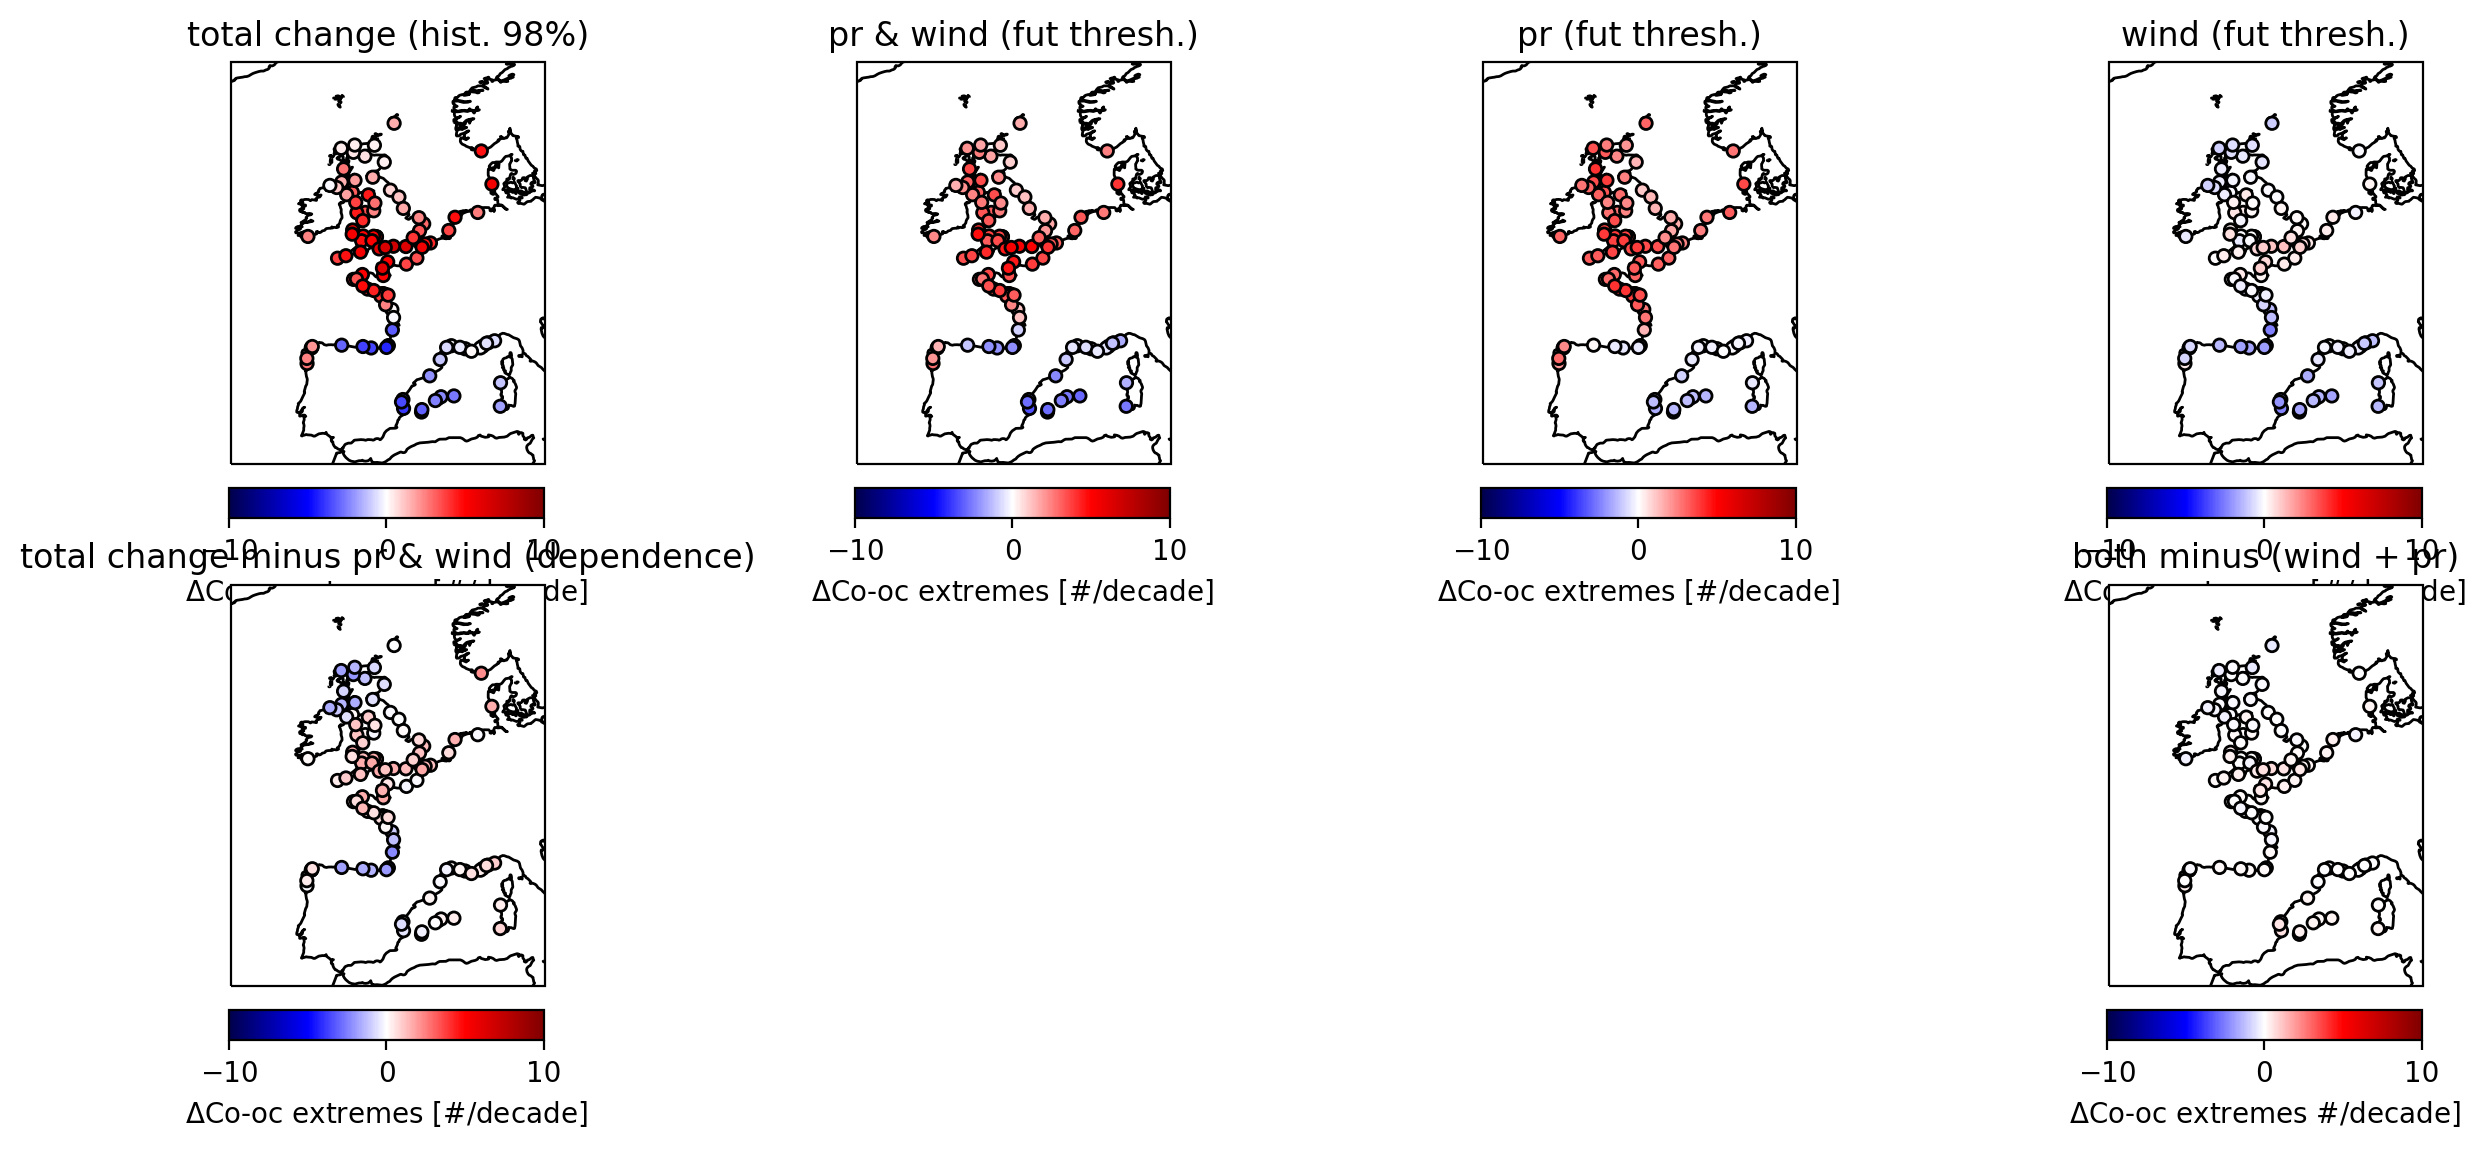

In [23]:
fig=plt.figure(figsize=(15,6)) #generate figure  
gs = fig.add_gridspec(2,4)
gs.update(wspace=.4,hspace=.3)

ssp='ssp585'
ssp_ds = ds_wind.sel(ssp=ssp).sum(dim='month',skipna=False)
#ssp_ds = ds_intersect.sel(ssp=ssp).sum(dim='month',skipna=False)
#ssp_ds = ds_intersect.sel(ssp=ssp).isel(month=-1) + ds_intersect.sel(ssp=ssp).isel(month=0) + ds_intersect.sel(ssp=ssp).isel(month=1) 
ssp_ds_present = ssp_ds.sel(window=2000)#.sel(window=2005)
ssp_ds_future = ssp_ds.sel(window=2080)#.sel(window=2085)
ssp_ds_diff = ssp_ds_future - ssp_ds_present

    
#1991-2020
ax = plt.subplot(gs[0,0],projection=ccrs.Robinson(central_longitude=0))

sc=ax.scatter(ssp_ds.lon,ssp_ds.lat,c=(.25*ssp_ds_diff.num_co_occurring.mean(dim='member_id').mean(dim='source_id')),cmap='seismic',vmin=-10,vmax=10,s=20,transform=ccrs.PlateCarree(),zorder=3,edgecolor='black')
#sc = (.25*ssp_ds_diff.num_co_occurring.mean(dim='member_id').mean(dim='source_id')).plot(ax=ax,transform=ccrs.PlateCarree(),vmin=-10,vmax=10,cmap='seismic',add_colorbar=False)

ax.coastlines(zorder=1)
ax.set_extent([-15, 12, 35, 65], crs=ccrs.PlateCarree())

cax=inset_axes(ax,width="100%", height="100%",bbox_to_anchor=(0.04, -.1,1,.075),bbox_transform=ax.transAxes)
cb=fig.colorbar(sc, cax=cax,orientation='horizontal',label='$\Delta$Co-oc extremes [#/decade]')
ax.set_title('total change (hist. 98%)')


ax = plt.subplot(gs[0,1],projection=ccrs.Robinson(central_longitude=0))

both_driven = (ssp_ds.num_co_occurring_both_driven-ssp_ds_present.num_co_occurring)

sc=ax.scatter(ssp_ds.lon,ssp_ds.lat,c=(.25*both_driven.mean(dim='member_id').mean(dim='source_id')),cmap='seismic',vmin=-10,vmax=10,s=20,transform=ccrs.PlateCarree(),zorder=3,edgecolor='black')
#sc = (.25*both_driven.mean(dim='member_id').mean(dim='source_id')).plot(ax=ax,transform=ccrs.PlateCarree(),vmin=-10,vmax=10,cmap='seismic',add_colorbar=False)

ax.coastlines(zorder=1)
ax.set_extent([-15, 12, 35, 65], crs=ccrs.PlateCarree())

cax=inset_axes(ax,width="100%", height="100%",bbox_to_anchor=(0.04, -.1,1,.075),bbox_transform=ax.transAxes)
cb=fig.colorbar(sc, cax=cax,orientation='horizontal',label='$\Delta$Co-oc extremes [#/decade]')
ax.set_title('pr & wind (fut thresh.)')

ax = plt.subplot(gs[0,2],projection=ccrs.Robinson(central_longitude=0))

pr_driven = (ssp_ds.num_co_occurring_pr_driven-ssp_ds_present.num_co_occurring)

sc=ax.scatter(ssp_ds.lon,ssp_ds.lat,c=(.25*pr_driven.mean(dim='member_id').mean(dim='source_id')),cmap='seismic',vmin=-10,vmax=10,s=20,transform=ccrs.PlateCarree(),zorder=3,edgecolor='black')
#sc = (.25*pr_driven.mean(dim='member_id').mean(dim='source_id')).plot(ax=ax,transform=ccrs.PlateCarree(),vmin=-10,vmax=10,cmap='seismic',add_colorbar=False)

ax.coastlines(zorder=1)
ax.set_extent([-15, 12, 35, 65], crs=ccrs.PlateCarree())
cax=inset_axes(ax,width="100%", height="100%",bbox_to_anchor=(0.04, -.1,1,.075),bbox_transform=ax.transAxes)
cb=fig.colorbar(sc, cax=cax,orientation='horizontal',label='$\Delta$Co-oc extremes [#/decade]')
ax.set_title('pr (fut thresh.)')


ax = plt.subplot(gs[0,3],projection=ccrs.Robinson(central_longitude=0))

sfcWind_driven = (ssp_ds.num_co_occurring_sfcWind_driven-ssp_ds_present.num_co_occurring)

sc=ax.scatter(ssp_ds.lon,ssp_ds.lat,c=(.25*sfcWind_driven.mean(dim='member_id').mean(dim='source_id')),cmap='seismic',vmin=-10,vmax=10,s=20,transform=ccrs.PlateCarree(),zorder=3,edgecolor='black')
#sc = (.25*sfcWind_driven.mean(dim='member_id').mean(dim='source_id')).plot(ax=ax,transform=ccrs.PlateCarree(),vmin=-10,vmax=10,cmap='seismic',add_colorbar=False)

ax.coastlines(zorder=1)
ax.set_extent([-15, 12, 35, 65], crs=ccrs.PlateCarree())

cax=inset_axes(ax,width="100%", height="100%",bbox_to_anchor=(0.04, -.1,1,.075),bbox_transform=ax.transAxes)
cb=fig.colorbar(sc, cax=cax,orientation='horizontal',label='$\Delta$Co-oc extremes [#/decade]')
ax.set_title('wind (fut thresh.)')    


#sc=ax.scatter(sfcWind_peaks_hist.lon,sfcWind_peaks_hist.lat,c=sfcWind_peaks_hist.has_track.sum(dim='time')/np.isfinite(sfcWind_peaks_hist.sfcWind).sum(dim='time'),cmap='Reds',vmin=0,vmax=.8,s=20,transform=ccrs.PlateCarree(),zorder=3)
#ax.set_extent([-15, 12, 35, 65], crs=ccrs.PlateCarree())

#cax=inset_axes(ax,width="100%", height="100%",bbox_to_anchor=(1.1, 0.035,.075,1),bbox_transform=ax.transAxes)
#cb=fig.colorbar(sc, cax=cax,orientation='vertical',label='Fraction etcs/extremes [-]')

ax = plt.subplot(gs[1,3],projection=ccrs.Robinson(central_longitude=0))

sc=ax.scatter(ssp_ds.lon,ssp_ds.lat,c=(.25*(both_driven-(sfcWind_driven+pr_driven)).mean(dim='member_id').mean(dim='source_id')),cmap='seismic',vmin=-10,vmax=10,s=20,transform=ccrs.PlateCarree(),zorder=3,edgecolor='black')
#sc = (.25*(both_driven-(sfcWind_driven+pr_driven)).mean(dim='member_id').mean(dim='source_id')).plot(ax=ax,transform=ccrs.PlateCarree(),vmin=-10,vmax=10,cmap='seismic',add_colorbar=False)

ax.coastlines(zorder=1)
ax.set_extent([-15, 12, 35, 65], crs=ccrs.PlateCarree())

cax=inset_axes(ax,width="100%", height="100%",bbox_to_anchor=(0.04, -.1,1,.075),bbox_transform=ax.transAxes)
cb=fig.colorbar(sc, cax=cax,orientation='horizontal',label='$\Delta$Co-oc extremes #/decade]')
ax.set_title('both minus (wind + pr)')   

dependence_driven = (ssp_ds_future.num_co_occurring-ssp_ds.num_co_occurring_both_driven)

ax = plt.subplot(gs[1,0],projection=ccrs.Robinson(central_longitude=0))

sc=ax.scatter(ssp_ds.lon,ssp_ds.lat,c=(.25*dependence_driven.mean(dim='member_id').mean(dim='source_id')),cmap='seismic',vmin=-10,vmax=10,s=20,transform=ccrs.PlateCarree(),zorder=3,edgecolor='black')
#sc = (.25*dependence_driven.mean(dim='member_id').mean(dim='source_id')).plot(ax=ax,transform=ccrs.PlateCarree(),vmin=-10,vmax=10,cmap='seismic',add_colorbar=False)

ax.coastlines(zorder=1)
ax.set_extent([-15, 12, 35, 65], crs=ccrs.PlateCarree())

cax=inset_axes(ax,width="100%", height="100%",bbox_to_anchor=(0.04, -.1,1,.075),bbox_transform=ax.transAxes)
cb=fig.colorbar(sc, cax=cax,orientation='horizontal',label='$\Delta$Co-oc extremes [#/decade]')
ax.set_title('total change minus pr & wind (dependence)')   

'''
ax = plt.subplot(gs[1,1],projection=ccrs.Robinson(central_longitude=0))

sc = (np.abs(dependence_driven.mean(dim='member_id').mean(dim='source_id'))>np.abs(pr_driven.mean(dim='member_id').mean(dim='source_id'))).plot(ax=ax,transform=ccrs.PlateCarree(),vmin=0,vmax=1,cmap='seismic',add_colorbar=False)

ax.coastlines(zorder=1)
ax.set_extent([-15, 12, 35, 65], crs=ccrs.PlateCarree())

cax=inset_axes(ax,width="100%", height="100%",bbox_to_anchor=(0.04, -.1,1,.075),bbox_transform=ax.transAxes)
cb=fig.colorbar(sc, cax=cax,orientation='horizontal',label='$\Delta$Co-oc extremes [#/decade]')
ax.set_title('dependence>pr')   

ax = plt.subplot(gs[1,2],projection=ccrs.Robinson(central_longitude=0))

sc = (np.abs(dependence_driven.mean(dim='member_id').mean(dim='source_id'))>np.abs(sfcWind_driven.mean(dim='member_id').mean(dim='source_id'))).plot(ax=ax,transform=ccrs.PlateCarree(),vmin=0,vmax=1,cmap='seismic',add_colorbar=False)

ax.coastlines(zorder=1)
ax.set_extent([-15, 12, 35, 65], crs=ccrs.PlateCarree())

cax=inset_axes(ax,width="100%", height="100%",bbox_to_anchor=(0.04, -.1,1,.075),bbox_transform=ax.transAxes)
cb=fig.colorbar(sc, cax=cax,orientation='horizontal',label='$\Delta$Co-oc extremes [#/decade]')
ax.set_title('dependence>wind')   
'''


'''
ax = plt.subplot(gs[1,0],projection=ccrs.Robinson(central_longitude=0))

sc = (.25*(mri_dependence.sel(member_id='r1i1p1f1',window=2080).num_co_occurring.sum(dim='month',skipna=False)-mri_dependence.sel(member_id='r1i1p1f1',window=1980).num_co_occurring.sum(dim='month',skipna=False))).plot(ax=ax,transform=ccrs.PlateCarree(),vmin=-10,vmax=10,cmap='seismic',add_colorbar=False)
ax.coastlines(zorder=2)

cax=inset_axes(ax,width="100%", height="100%",bbox_to_anchor=(0.04, -.1,1,.075),bbox_transform=ax.transAxes)
cb=fig.colorbar(sc, cax=cax,orientation='horizontal',label='$\Delta$Co-oc extremes [#/decade]')
ax.set_title('total change (recomputing 98%)')   


ax = plt.subplot(gs[1,1],projection=ccrs.Robinson(central_longitude=0))

sc = (.25*(num_co_occurring.mean(dim='member_id').sel(window=2080)-mri_dependence.sel(member_id='r1i1p1f1',window=2080).num_co_occurring.sum(dim='month',skipna=False))).plot(ax=ax,transform=ccrs.PlateCarree(),vmin=-10,vmax=10,cmap='seismic',add_colorbar=False)
ax.coastlines(zorder=2)

cax=inset_axes(ax,width="100%", height="100%",bbox_to_anchor=(0.04, -.1,1,.075),bbox_transform=ax.transAxes)
cb=fig.colorbar(sc, cax=cax,orientation='horizontal',label='$\Delta$Co-oc extremes [#/decade]')
ax.set_title('d98-d97 future')   
'''


Uncertainty in terms:

'\nax = plt.subplot(gs[1,0],projection=ccrs.Robinson(central_longitude=0))\n\nsc = (.25*(mri_dependence.sel(member_id=\'r1i1p1f1\',window=2080).num_co_occurring.sum(dim=\'month\',skipna=False)-mri_dependence.sel(member_id=\'r1i1p1f1\',window=1980).num_co_occurring.sum(dim=\'month\',skipna=False))).plot(ax=ax,transform=ccrs.PlateCarree(),vmin=0,vmax=6,cmap=\'Reds\',add_colorbar=False)\nax.coastlines(zorder=2)\n\ncax=inset_axes(ax,width="100%", height="100%",bbox_to_anchor=(0.04, -.1,1,.075),bbox_transform=ax.transAxes)\ncb=fig.colorbar(sc, cax=cax,orientation=\'horizontal\',label=\'$\\Delta$Co-oc extremes [#/decade]\')\nax.set_title(\'total change (recomputing 98%)\')   \n\n\nax = plt.subplot(gs[1,1],projection=ccrs.Robinson(central_longitude=0))\n\nsc = (.25*(num_co_occurring.mean(dim=\'member_id\').sel(window=2080)-mri_dependence.sel(member_id=\'r1i1p1f1\',window=2080).num_co_occurring.sum(dim=\'month\',skipna=False))).plot(ax=ax,transform=ccrs.PlateCarree(),vmin=0,vmax=6,cmap=\'Reds\

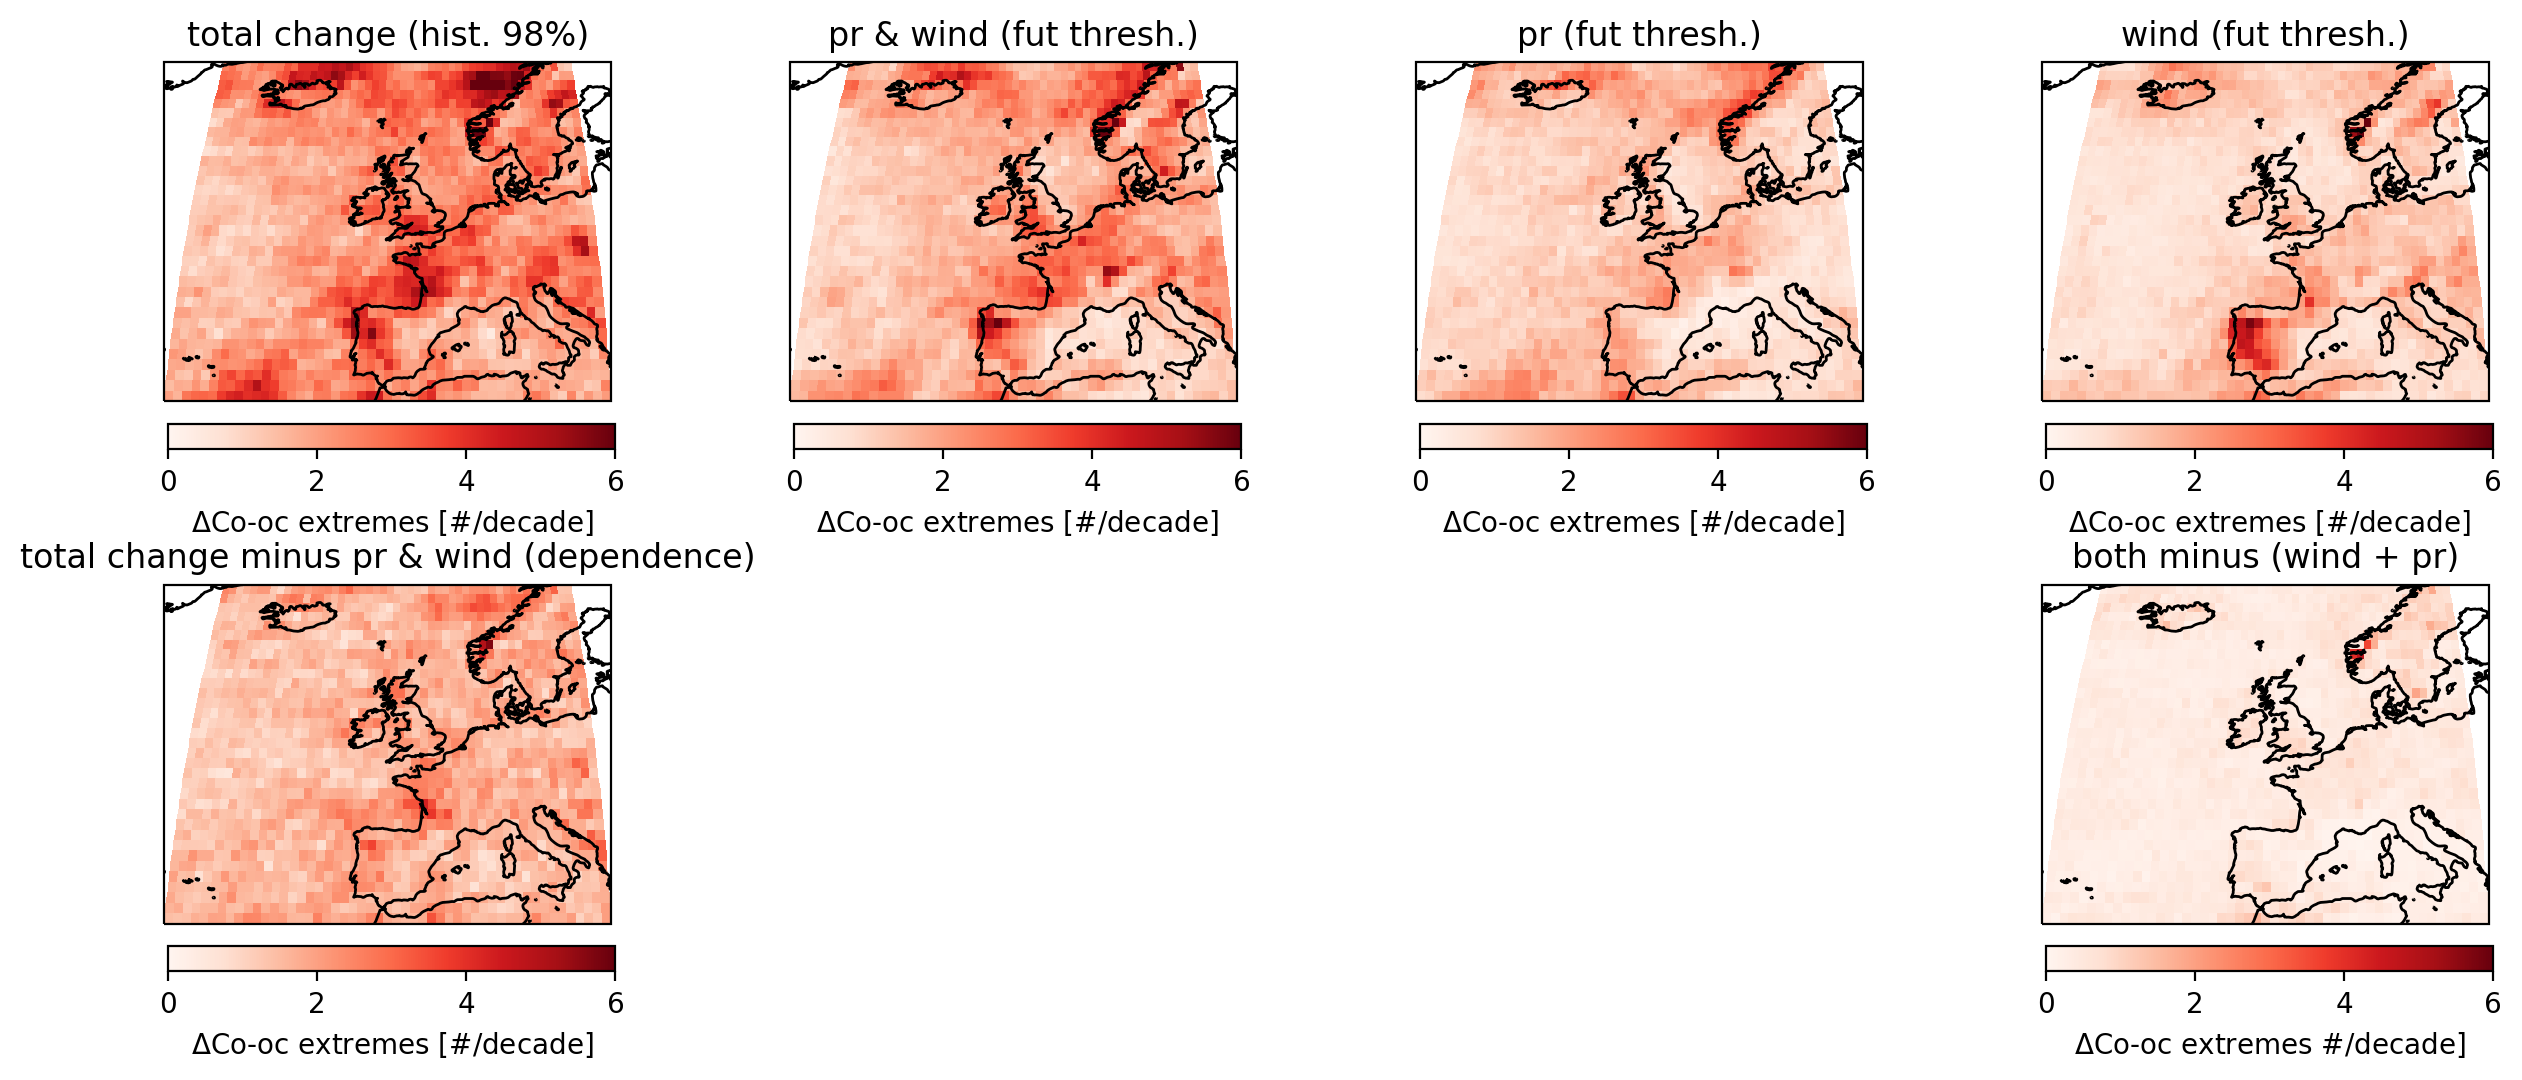

In [37]:
fig=plt.figure(figsize=(15,6)) #generate figure  
gs = fig.add_gridspec(2,4)
gs.update(wspace=.4,hspace=.3)

ssp='ssp585'

ssp_ds = ds_intersect.sel(ssp=ssp).sum(dim='month',skipna=False)
#ssp_ds = ds_intersect.sel(ssp=ssp).isel(month=-1) + ds_intersect.sel(ssp=ssp).isel(month=0) + ds_intersect.sel(ssp=ssp).isel(month=1) 
ssp_ds_present = ssp_ds.sel(window=2000)#.sel(window=2005)
ssp_ds_future = ssp_ds.sel(window=2080)#.sel(window=2085)
ssp_ds_diff = ssp_ds_future - ssp_ds_present

    
#1991-2020
ax = plt.subplot(gs[0,0],projection=ccrs.Robinson(central_longitude=0))

sc = (.25*ssp_ds_diff.num_co_occurring.mean(dim='member_id').std(dim='source_id')).plot(ax=ax,transform=ccrs.PlateCarree(),vmin=0,vmax=6,cmap='Reds',add_colorbar=False)

ax.coastlines(zorder=2)

cax=inset_axes(ax,width="100%", height="100%",bbox_to_anchor=(0.04, -.1,1,.075),bbox_transform=ax.transAxes)
cb=fig.colorbar(sc, cax=cax,orientation='horizontal',label='$\Delta$Co-oc extremes [#/decade]')
ax.set_title('total change (hist. 98%)')


ax = plt.subplot(gs[0,1],projection=ccrs.Robinson(central_longitude=0))

both_driven = (ssp_ds.num_co_occurring_both_driven-ssp_ds_present.num_co_occurring)

sc = (.25*both_driven.mean(dim='member_id').std(dim='source_id')).plot(ax=ax,transform=ccrs.PlateCarree(),vmin=0,vmax=6,cmap='Reds',add_colorbar=False)

ax.coastlines(zorder=2)

cax=inset_axes(ax,width="100%", height="100%",bbox_to_anchor=(0.04, -.1,1,.075),bbox_transform=ax.transAxes)
cb=fig.colorbar(sc, cax=cax,orientation='horizontal',label='$\Delta$Co-oc extremes [#/decade]')
ax.set_title('pr & wind (fut thresh.)')

ax = plt.subplot(gs[0,2],projection=ccrs.Robinson(central_longitude=0))

pr_driven = (ssp_ds.num_co_occurring_pr_driven-ssp_ds_present.num_co_occurring)

sc = (.25*pr_driven.mean(dim='member_id').std(dim='source_id')).plot(ax=ax,transform=ccrs.PlateCarree(),vmin=0,vmax=6,cmap='Reds',add_colorbar=False)

ax.coastlines(zorder=2)

cax=inset_axes(ax,width="100%", height="100%",bbox_to_anchor=(0.04, -.1,1,.075),bbox_transform=ax.transAxes)
cb=fig.colorbar(sc, cax=cax,orientation='horizontal',label='$\Delta$Co-oc extremes [#/decade]')
ax.set_title('pr (fut thresh.)')


ax = plt.subplot(gs[0,3],projection=ccrs.Robinson(central_longitude=0))

sfcWind_driven = (ssp_ds.num_co_occurring_sfcWind_driven-ssp_ds_present.num_co_occurring)

sc = (.25*sfcWind_driven.mean(dim='member_id').std(dim='source_id')).plot(ax=ax,transform=ccrs.PlateCarree(),vmin=0,vmax=6,cmap='Reds',add_colorbar=False)

ax.coastlines(zorder=2)

cax=inset_axes(ax,width="100%", height="100%",bbox_to_anchor=(0.04, -.1,1,.075),bbox_transform=ax.transAxes)
cb=fig.colorbar(sc, cax=cax,orientation='horizontal',label='$\Delta$Co-oc extremes [#/decade]')
ax.set_title('wind (fut thresh.)')    


#sc=ax.scatter(sfcWind_peaks_hist.lon,sfcWind_peaks_hist.lat,c=sfcWind_peaks_hist.has_track.sum(dim='time')/np.isfinite(sfcWind_peaks_hist.sfcWind).sum(dim='time'),cmap='Reds',vmin=0,vmax=.8,s=20,transform=ccrs.PlateCarree(),zorder=3)
#ax.set_extent([-15, 12, 35, 65], crs=ccrs.PlateCarree())

#cax=inset_axes(ax,width="100%", height="100%",bbox_to_anchor=(1.1, 0.035,.075,1),bbox_transform=ax.transAxes)
#cb=fig.colorbar(sc, cax=cax,orientation='vertical',label='Fraction etcs/extremes [-]')

ax = plt.subplot(gs[1,3],projection=ccrs.Robinson(central_longitude=0))

sc = (.25*(both_driven-(sfcWind_driven+pr_driven)).mean(dim='member_id').std(dim='source_id')).plot(ax=ax,transform=ccrs.PlateCarree(),vmin=0,vmax=6,cmap='Reds',add_colorbar=False)

ax.coastlines(zorder=2)

cax=inset_axes(ax,width="100%", height="100%",bbox_to_anchor=(0.04, -.1,1,.075),bbox_transform=ax.transAxes)
cb=fig.colorbar(sc, cax=cax,orientation='horizontal',label='$\Delta$Co-oc extremes #/decade]')
ax.set_title('both minus (wind + pr)')   

dependence_driven = (ssp_ds_future.num_co_occurring-ssp_ds.num_co_occurring_both_driven)

ax = plt.subplot(gs[1,0],projection=ccrs.Robinson(central_longitude=0))

sc = (.25*dependence_driven.mean(dim='member_id').std(dim='source_id')).plot(ax=ax,transform=ccrs.PlateCarree(),vmin=0,vmax=6,cmap='Reds',add_colorbar=False)

ax.coastlines(zorder=2)

cax=inset_axes(ax,width="100%", height="100%",bbox_to_anchor=(0.04, -.1,1,.075),bbox_transform=ax.transAxes)
cb=fig.colorbar(sc, cax=cax,orientation='horizontal',label='$\Delta$Co-oc extremes [#/decade]')
ax.set_title('total change minus pr & wind (dependence)')   

'''
ax = plt.subplot(gs[1,1],projection=ccrs.Robinson(central_longitude=0))

sc = (np.abs(dependence_driven.mean(dim='member_id').mean(dim='source_id'))>np.abs(pr_driven.mean(dim='member_id').mean(dim='source_id'))).plot(ax=ax,transform=ccrs.PlateCarree(),vmin=0,vmax=1,cmap='Reds',add_colorbar=False)

ax.coastlines(zorder=2)

cax=inset_axes(ax,width="100%", height="100%",bbox_to_anchor=(0.04, -.1,1,.075),bbox_transform=ax.transAxes)
cb=fig.colorbar(sc, cax=cax,orientation='horizontal',label='$\Delta$Co-oc extremes [#/decade]')
ax.set_title('dependence>pr')   

ax = plt.subplot(gs[1,2],projection=ccrs.Robinson(central_longitude=0))

sc = (np.abs(dependence_driven.mean(dim='member_id').mean(dim='source_id'))>np.abs(sfcWind_driven.mean(dim='member_id').mean(dim='source_id'))).plot(ax=ax,transform=ccrs.PlateCarree(),vmin=0,vmax=1,cmap='Reds',add_colorbar=False)

ax.coastlines(zorder=2)

cax=inset_axes(ax,width="100%", height="100%",bbox_to_anchor=(0.04, -.1,1,.075),bbox_transform=ax.transAxes)
cb=fig.colorbar(sc, cax=cax,orientation='horizontal',label='$\Delta$Co-oc extremes [#/decade]')
ax.set_title('dependence>wind')   
'''


'''
ax = plt.subplot(gs[1,0],projection=ccrs.Robinson(central_longitude=0))

sc = (.25*(mri_dependence.sel(member_id='r1i1p1f1',window=2080).num_co_occurring.sum(dim='month',skipna=False)-mri_dependence.sel(member_id='r1i1p1f1',window=1980).num_co_occurring.sum(dim='month',skipna=False))).plot(ax=ax,transform=ccrs.PlateCarree(),vmin=0,vmax=6,cmap='Reds',add_colorbar=False)
ax.coastlines(zorder=2)

cax=inset_axes(ax,width="100%", height="100%",bbox_to_anchor=(0.04, -.1,1,.075),bbox_transform=ax.transAxes)
cb=fig.colorbar(sc, cax=cax,orientation='horizontal',label='$\Delta$Co-oc extremes [#/decade]')
ax.set_title('total change (recomputing 98%)')   


ax = plt.subplot(gs[1,1],projection=ccrs.Robinson(central_longitude=0))

sc = (.25*(num_co_occurring.mean(dim='member_id').sel(window=2080)-mri_dependence.sel(member_id='r1i1p1f1',window=2080).num_co_occurring.sum(dim='month',skipna=False))).plot(ax=ax,transform=ccrs.PlateCarree(),vmin=0,vmax=6,cmap='Reds',add_colorbar=False)
ax.coastlines(zorder=2)

cax=inset_axes(ax,width="100%", height="100%",bbox_to_anchor=(0.04, -.1,1,.075),bbox_transform=ax.transAxes)
cb=fig.colorbar(sc, cax=cax,orientation='horizontal',label='$\Delta$Co-oc extremes [#/decade]')
ax.set_title('d98-d97 future')   
'''


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


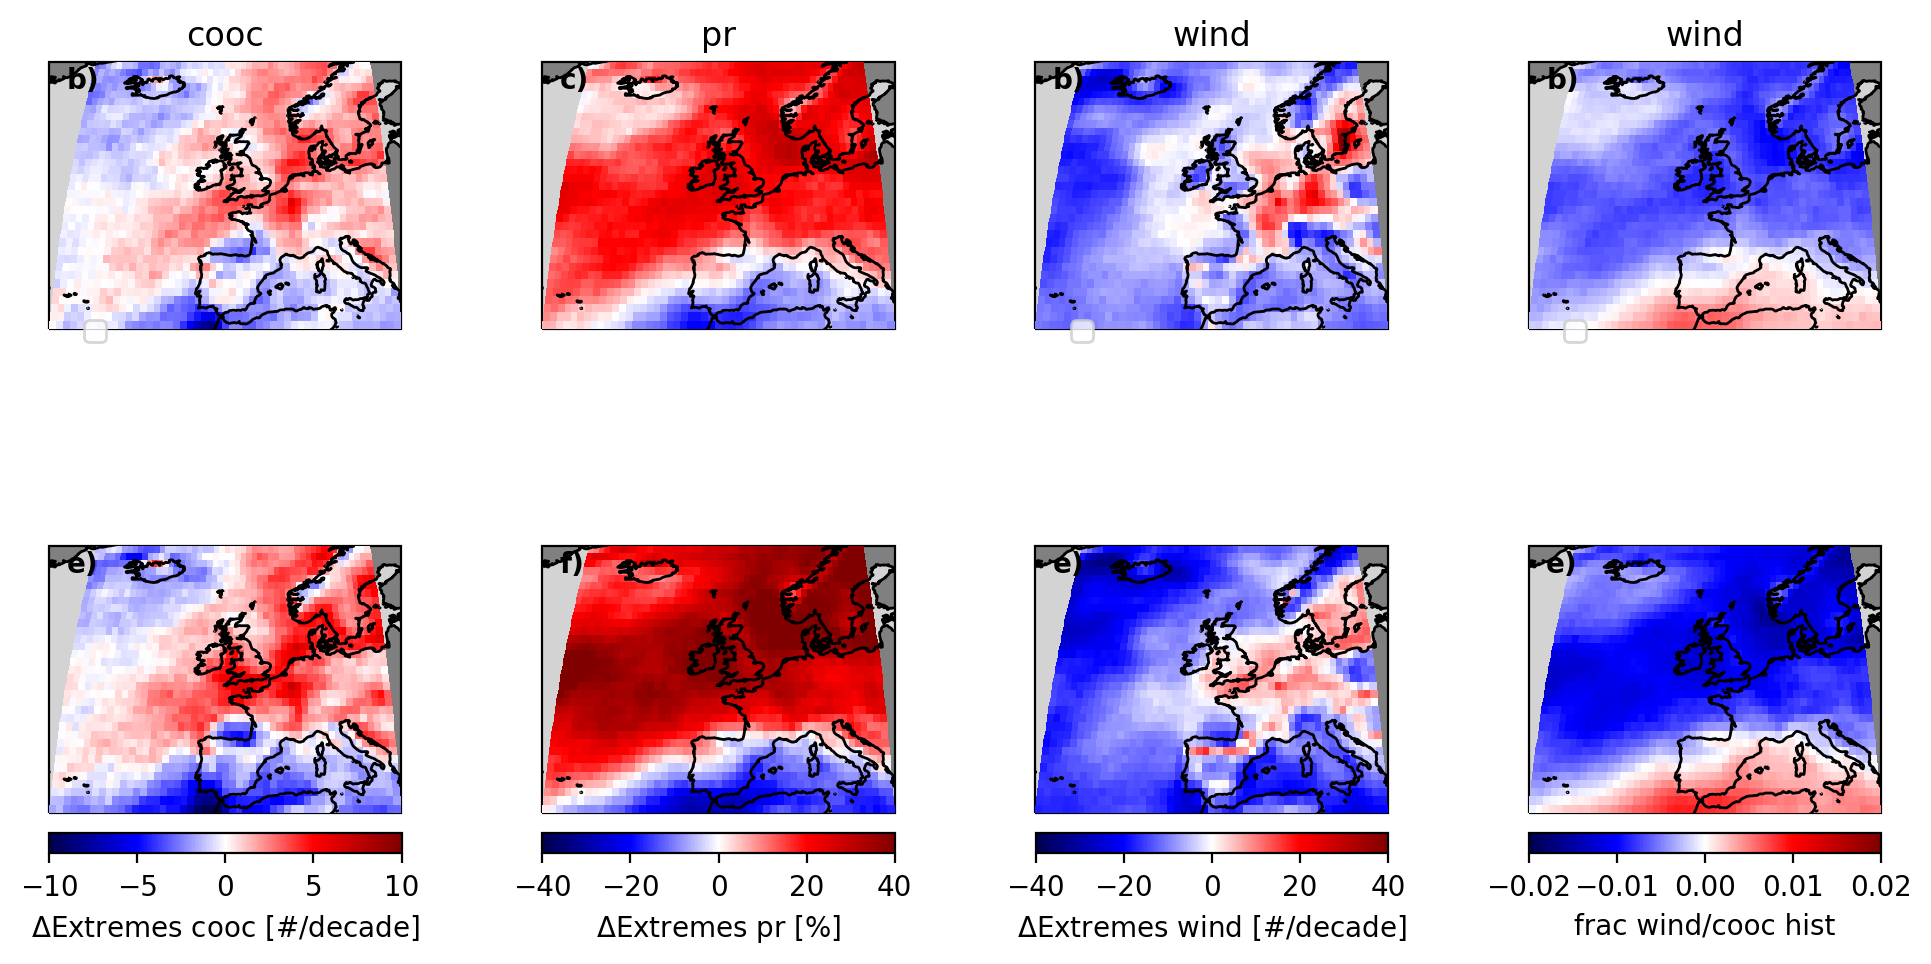

In [9]:
fig=plt.figure(figsize=(15,6)) #generate figure  
gs = fig.add_gridspec(2,5)
gs.update(wspace=.4,hspace=.1)
    
for s,ssp in enumerate(ssps):
    ssp_ds = ds_intersect.sel(ssp=ssp).sum(dim='month',skipna=False)
    #ssp_ds = ds_intersect.sel(ssp=ssp).isel(month=-1) + ds_intersect.sel(ssp=ssp).isel(month=0) + ds_intersect.sel(ssp=ssp).isel(month=1) 
    ssp_ds_present = ssp_ds.sel(window=2000)#.sel(window=2005)
    ssp_ds_future = ssp_ds.sel(window=2080)#.sel(window=2085)
    ssp_ds_diff = ssp_ds_future - ssp_ds_present


    ax = plt.subplot(gs[s,1],projection=ccrs.Robinson(central_longitude=0))

    ax.add_feature(cartopy.feature.OCEAN, zorder=0,facecolor='lightgrey')
    ax.add_feature(cartopy.feature.LAND, zorder=0, facecolor='grey')

    #sc=ax.scatter(ssp_ds.lon[~fraction_exceeds],ssp_ds.lat[~fraction_exceeds],c=.25*ssp_ds_diff.num_co_occurring.mean(dim='member_id').mean(dim='source_id')[~fraction_exceeds],cmap='seismic',vmin=-10,vmax=10,s=20,transform=ccrs.PlateCarree(),zorder=3)
    #sc=ax.scatter(ssp_ds.lon[fraction_exceeds],ssp_ds.lat[fraction_exceeds],c=.25*ssp_ds_diff.num_co_occurring.mean(dim='member_id').mean(dim='source_id')[fraction_exceeds],cmap='seismic',vmin=-10,vmax=10,s=20,edgecolor='black',transform=ccrs.PlateCarree(),zorder=3,label='$\geq$75% agree')
    sc=(.25*ssp_ds_diff.num_co_occurring.mean(dim='member_id').mean(dim='source_id')).plot(cmap='seismic',vmin=-10,vmax=10,transform=ccrs.PlateCarree(),zorder=3,ax=ax,add_colorbar=False)
    ax.coastlines(zorder=5)
    #ax.set_extent([-15, 12, 35, 65], crs=ccrs.PlateCarree())

    if s==0:
        ax.legend(ncols=1,markerscale=1,loc=(.1,-.05),frameon=True)
        ax.set_title('cooc')
    if s==1:
        ax.set_title('')
        cax=inset_axes(ax,width="100%", height="100%",bbox_to_anchor=(0.04, -.1,1,.075),bbox_transform=ax.transAxes)
        cb=fig.colorbar(sc, cax=cax,orientation='horizontal',label='$\Delta$Extremes cooc [#/decade]')
    ax.annotate('be'[s]+')',(.05,.9),xycoords='axes fraction',fontweight='bold')    
        
    ax = plt.subplot(gs[s,2],projection=ccrs.Robinson(central_longitude=0))

    ax.add_feature(cartopy.feature.OCEAN, zorder=0,facecolor='lightgrey')
    ax.add_feature(cartopy.feature.LAND, zorder=0, facecolor='grey')

    sc=(.25*ssp_ds_diff.num_pr_peaks.mean(dim='member_id').mean(dim='source_id')).plot(cmap='seismic',vmin=-40,vmax=40,transform=ccrs.PlateCarree(),zorder=3,ax=ax,add_colorbar=False)
    ax.coastlines(zorder=5)
    #ax.set_extent([-15, 12, 35, 65], crs=ccrs.PlateCarree())

    if s==1:
        cax=inset_axes(ax,width="100%", height="100%",bbox_to_anchor=(0.04, -.1,1,.075),bbox_transform=ax.transAxes)
        cb=fig.colorbar(sc, cax=cax,orientation='horizontal',label='$\Delta$Extremes pr [%]')
        ax.set_title('')
    if s==0:
        ax.set_title('pr')
    ax.annotate('cf'[s]+')',(.05,.9),xycoords='axes fraction',fontweight='bold')
#meaning of number of joint extremes?

#fig.savefig('Figures/ensmean_num_joint_extremes_knmi.pdf',format='pdf',dpi=300,bbox_inches='tight')


    
    ax = plt.subplot(gs[s,3],projection=ccrs.Robinson(central_longitude=0))

    ax.add_feature(cartopy.feature.OCEAN, zorder=0,facecolor='lightgrey')
    ax.add_feature(cartopy.feature.LAND, zorder=0, facecolor='grey')

    
    sc=(.25*ssp_ds_diff.num_sfcWind_peaks.mean(dim='member_id').mean(dim='source_id')).plot(cmap='seismic',vmin=-40,vmax=40,transform=ccrs.PlateCarree(),zorder=3,ax=ax,add_colorbar=False)
    ax.coastlines(zorder=5)    
    #ax.set_extent([-15, 12, 35, 65], crs=ccrs.PlateCarree())

    if s==0:
        ax.legend(ncols=1,markerscale=1,loc=(.1,-.05),frameon=True)
        ax.set_title('wind')
    if s==1:
        ax.set_title('')
        cax=inset_axes(ax,width="100%", height="100%",bbox_to_anchor=(0.04, -.1,1,.075),bbox_transform=ax.transAxes)
        cb=fig.colorbar(sc, cax=cax,orientation='horizontal',label='$\Delta$Extremes wind [#/decade]')
    ax.annotate('be'[s]+')',(.05,.9),xycoords='axes fraction',fontweight='bold')    
    
        
    ax = plt.subplot(gs[s,4],projection=ccrs.Robinson(central_longitude=0))

    ax.add_feature(cartopy.feature.OCEAN, zorder=0,facecolor='lightgrey')
    ax.add_feature(cartopy.feature.LAND, zorder=0, facecolor='grey')

    
    sc=((1-ssp_ds_future.num_pr_peaks/(365*40)).mean(dim='member_id').mean(dim='source_id')-.98).plot(cmap='seismic',vmin=-.02,vmax=.02,transform=ccrs.PlateCarree(),zorder=3,ax=ax,add_colorbar=False)
    ax.coastlines(zorder=5)    
    #ax.set_extent([-15, 12, 35, 65], crs=ccrs.PlateCarree())

    if s==0:
        ax.legend(ncols=1,markerscale=1,loc=(.1,-.05),frameon=True)
        ax.set_title('wind')
    if s==1:
        ax.set_title('')
        cax=inset_axes(ax,width="100%", height="100%",bbox_to_anchor=(0.04, -.1,1,.075),bbox_transform=ax.transAxes)
        cb=fig.colorbar(sc, cax=cax,orientation='horizontal',label='frac wind/cooc hist')
    ax.annotate('be'[s]+')',(.05,.9),xycoords='axes fraction',fontweight='bold')    
    

In [10]:
0.97*0.97

0.9409

AttributeError: 'Dataset' object has no attribute 'sfcWind_thresholds'

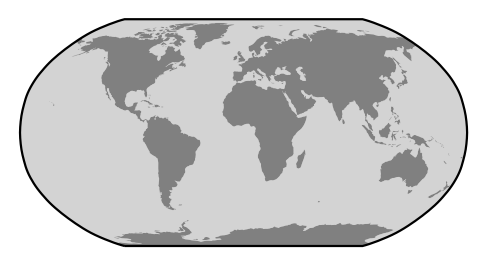

In [11]:
fig=plt.figure(figsize=(15,6)) #generate figure  
gs = fig.add_gridspec(2,4)
gs.update(wspace=.4,hspace=.1)
    
for s,ssp in enumerate(ssps):
    ssp_ds = ds_intersect.sel(ssp=ssp).sum(dim='month',skipna=False)
    #ssp_ds = ds_intersect.sel(ssp=ssp).isel(month=-1) + ds_intersect.sel(ssp=ssp).isel(month=0) + ds_intersect.sel(ssp=ssp).isel(month=1) 
    ssp_ds_present = ssp_ds.sel(window=2000)#.sel(window=2005)
    ssp_ds_future = ssp_ds.sel(window=2080)#.sel(window=2085)
    ssp_ds_diff = ssp_ds_future - ssp_ds_present

    #1991-2020
    ax = plt.subplot(gs[s,0],projection=ccrs.Robinson(central_longitude=0))

    ax.add_feature(cartopy.feature.OCEAN, zorder=0,facecolor='lightgrey')
    ax.add_feature(cartopy.feature.LAND, zorder=0, facecolor='grey')

    sc=(.25*ssp_ds_present.sfcWind_thresholds.isel(quantile=8).mean(dim='member_id').mean(dim='source_id')).plot(cmap='Reds',vmin=0,vmax=20,transform=ccrs.PlateCarree(),zorder=3,ax=ax,add_colorbar=False)
    ax.coastlines(zorder=5)
    #sc=ax.scatter(ssp_ds.lon,ssp_ds.lat,c=.25*ssp_ds_present.num_co_occurring.mean(dim='member_id').mean(dim='source_id'),cmap='Reds',vmin=0,vmax=30,s=20,transform=ccrs.PlateCarree(),zorder=3)
    #ax.set_extent([-15, 12, 35, 65], crs=ccrs.PlateCarree())

    if s==1:
        cax=inset_axes(ax,width="100%", height="100%",bbox_to_anchor=(0.04, -.1,1,.075),bbox_transform=ax.transAxes)
        cb=fig.colorbar(sc, cax=cax,orientation='horizontal',label='98% wind')
        ax.set_title('')
    if s==0:
        ax.set_title('1981-2020')

    ax.annotate(['SSP2-4.5','SSP5-8.5'][s],(-.2,.35),xycoords='axes fraction',rotation=90)
    ax.annotate('ad'[s]+')',(.05,.9),xycoords='axes fraction',fontweight='bold')
       
    ax = plt.subplot(gs[s,1],projection=ccrs.Robinson(central_longitude=0))

    ax.add_feature(cartopy.feature.OCEAN, zorder=0,facecolor='lightgrey')
    ax.add_feature(cartopy.feature.LAND, zorder=0, facecolor='grey')

    
    diff = ssp_ds_diff.num_co_occurring.mean(dim='member_id')
    ens_diff = ssp_ds_diff.num_co_occurring.mean(dim='member_id').mean(dim='source_id')

    num_agree = ((diff*ens_diff)>0).sum(dim='source_id')
    fraction_exceeds = (num_agree>=.75*len(diff.source_id))
        
    #sc=ax.scatter(ssp_ds.lon[~fraction_exceeds],ssp_ds.lat[~fraction_exceeds],c=.25*ssp_ds_diff.num_co_occurring.mean(dim='member_id').mean(dim='source_id')[~fraction_exceeds],cmap='seismic',vmin=-10,vmax=10,s=20,transform=ccrs.PlateCarree(),zorder=3)
    #sc=ax.scatter(ssp_ds.lon[fraction_exceeds],ssp_ds.lat[fraction_exceeds],c=.25*ssp_ds_diff.num_co_occurring.mean(dim='member_id').mean(dim='source_id')[fraction_exceeds],cmap='seismic',vmin=-10,vmax=10,s=20,edgecolor='black',transform=ccrs.PlateCarree(),zorder=3,label='$\geq$75% agree')
    sc=(.25*ssp_ds_diff.sfcWind_thresholds.isel(quantile=8).mean(dim='member_id').mean(dim='source_id')).plot(cmap='seismic',vmin=-.3,vmax=.3,transform=ccrs.PlateCarree(),zorder=3,ax=ax,add_colorbar=False)
    ax.coastlines(zorder=5)
    #ax.set_extent([-15, 12, 35, 65], crs=ccrs.PlateCarree())

    if s==0:
        ax.legend(ncols=1,markerscale=1,loc=(.1,-.05),frameon=True)
        ax.set_title('Projected change')
    if s==1:
        ax.set_title('')
        cax=inset_axes(ax,width="100%", height="100%",bbox_to_anchor=(0.04, -.1,1,.075),bbox_transform=ax.transAxes)
        cb=fig.colorbar(sc, cax=cax,orientation='horizontal',label='d98% Wind')
    ax.annotate('be'[s]+')',(.05,.9),xycoords='axes fraction',fontweight='bold')    
        
    ax = plt.subplot(gs[s,2],projection=ccrs.Robinson(central_longitude=0))

    ax.add_feature(cartopy.feature.OCEAN, zorder=0,facecolor='lightgrey')
    ax.add_feature(cartopy.feature.LAND, zorder=0, facecolor='grey')

    sc=(100*ssp_ds_diff.sfcWind_thresholds.isel(quantile=8)/ssp_ds_present.sfcWind_thresholds.isel(quantile=8)).mean(dim='member_id').mean(dim='source_id').plot(cmap='seismic',vmin=-15,vmax=15,transform=ccrs.PlateCarree(),zorder=3,add_colorbar=False)
    ax.coastlines(zorder=5)
    #ax.set_extent([-15, 12, 35, 65], crs=ccrs.PlateCarree())

    if s==1:
        cax=inset_axes(ax,width="100%", height="100%",bbox_to_anchor=(0.04, -.1,1,.075),bbox_transform=ax.transAxes)
        cb=fig.colorbar(sc, cax=cax,orientation='horizontal',label='d98% Wind [%]')
        ax.set_title('')
    if s==0:
        ax.set_title('% change')
    ax.annotate('cf'[s]+')',(.05,.9),xycoords='axes fraction',fontweight='bold')
#meaning of number of joint extremes?

#fig.savefig('Figures/ensmean_num_joint_extremes_knmi.pdf',format='pdf',dpi=300,bbox_inches='tight')


    
    '''
    #fraction
    ax = plt.subplot(gs[s,4],projection=ccrs.Robinson(central_longitude=0))

    ax.add_feature(cartopy.feature.OCEAN, zorder=0,facecolor='lightgrey')
    ax.add_feature(cartopy.feature.LAND, zorder=0, facecolor='grey')

    slope = (1/np.diff(ds.window)[0])*xr.corr(ssp_ds.num_sfcWind_peaks,timesteps,dim='window')*ssp_ds.num_sfcWind_peaks.std(dim='window')/timesteps.std(dim='window')
    sc=ax.scatter(ssp_ds.lon,ssp_ds.lat,c=.25*slope.mean(dim='member_id').mean(dim='source_id'),cmap='seismic',vmin=-.1,vmax=.1,s=20,transform=ccrs.PlateCarree(),zorder=3,label='$\geq$75% agree')
    
    ax.set_extent([-15, 12, 35, 65], crs=ccrs.PlateCarree())

    if s==0:
        #ax.legend(ncols=1,markerscale=1,loc=(.1,-.05),frameon=True)
        ax.set_title('slope sfcWind')
    if s==1:
        
        cax=inset_axes(ax,width="100%", height="100%",bbox_to_anchor=(0.04, -.1,1,.075),bbox_transform=ax.transAxes)
        cb=fig.colorbar(sc, cax=cax,orientation='horizontal',label='$\Delta$Extremes [#/decade]')
    ax.annotate('be'[s]+')',(.05,.9),xycoords='axes fraction',fontweight='bold')  
    
    
    ax = plt.subplot(gs[s,5],projection=ccrs.Robinson(central_longitude=0))

    ax.add_feature(cartopy.feature.OCEAN, zorder=0,facecolor='lightgrey')
    ax.add_feature(cartopy.feature.LAND, zorder=0, facecolor='grey')

    slope = (1/np.diff(ds.window)[0])*xr.corr(ssp_ds.num_pr_peaks,timesteps,dim='window')*ssp_ds.num_pr_peaks.std(dim='window')/timesteps.std(dim='window')
    sc=ax.scatter(ssp_ds.lon,ssp_ds.lat,c=.25*slope.mean(dim='member_id').mean(dim='source_id'),cmap='seismic',vmin=-.1,vmax=.1,s=20,transform=ccrs.PlateCarree(),zorder=3,label='$\geq$75% agree')
    
    ax.set_extent([-15, 12, 35, 65], crs=ccrs.PlateCarree())

    if s==0:
        #ax.legend(ncols=1,markerscale=1,loc=(.1,-.05),frameon=True)
        ax.set_title('slope pr')
    if s==1:
        
        cax=inset_axes(ax,width="100%", height="100%",bbox_to_anchor=(0.04, -.1,1,.075),bbox_transform=ax.transAxes)
        cb=fig.colorbar(sc, cax=cax,orientation='horizontal',label='$\Delta$Extremes [#/decade]')
    ax.annotate('be'[s]+')',(.05,.9),xycoords='axes fraction',fontweight='bold')    
    '''

In [ ]:
ds_intersect

In [ ]:
fig=plt.figure(figsize=(15,6)) #generate figure  
gs = fig.add_gridspec(2,4)
gs.update(wspace=.4,hspace=.1)
    
for s,ssp in enumerate(ssps):
    ssp_ds = ds_intersect.sel(ssp=ssp).sum(dim='month',skipna=False)
    #ssp_ds = ds_intersect.sel(ssp=ssp).isel(month=-1) + ds_intersect.sel(ssp=ssp).isel(month=0) + ds_intersect.sel(ssp=ssp).isel(month=1) 
    ssp_ds_present = ssp_ds.sel(window=2000)#.sel(window=2005)
    ssp_ds_future = ssp_ds.sel(window=2080)#.sel(window=2085)
    ssp_ds_diff = ssp_ds_future - ssp_ds_present

    #1991-2020
    ax = plt.subplot(gs[s,0],projection=ccrs.Robinson(central_longitude=0))

    ax.add_feature(cartopy.feature.OCEAN, zorder=0,facecolor='lightgrey')
    ax.add_feature(cartopy.feature.LAND, zorder=0, facecolor='grey')

    sc=(.25*ssp_ds_present.pr_thresholds.isel(quantile=8).mean(dim='member_id').mean(dim='source_id')).plot(cmap='Reds',vmin=0.002,vmax=.010,transform=ccrs.PlateCarree(),zorder=3,ax=ax,add_colorbar=False)
    ax.coastlines(zorder=5)
    #sc=ax.scatter(ssp_ds.lon,ssp_ds.lat,c=.25*ssp_ds_present.num_co_occurring.mean(dim='member_id').mean(dim='source_id'),cmap='Reds',vmin=0,vmax=30,s=20,transform=ccrs.PlateCarree(),zorder=3)
    #ax.set_extent([-15, 12, 35, 65], crs=ccrs.PlateCarree())

    if s==1:
        cax=inset_axes(ax,width="100%", height="100%",bbox_to_anchor=(0.04, -.1,1,.075),bbox_transform=ax.transAxes)
        cb=fig.colorbar(sc, cax=cax,orientation='horizontal',label='98% pr')
        ax.set_title('')
    if s==0:
        ax.set_title('1981-2020')

    ax.annotate(['SSP2-4.5','SSP5-8.5'][s],(-.2,.35),xycoords='axes fraction',rotation=90)
    ax.annotate('ad'[s]+')',(.05,.9),xycoords='axes fraction',fontweight='bold')
       
    ax = plt.subplot(gs[s,1],projection=ccrs.Robinson(central_longitude=0))

    ax.add_feature(cartopy.feature.OCEAN, zorder=0,facecolor='lightgrey')
    ax.add_feature(cartopy.feature.LAND, zorder=0, facecolor='grey')

    
    diff = ssp_ds_diff.num_co_occurring.mean(dim='member_id')
    ens_diff = ssp_ds_diff.num_co_occurring.mean(dim='member_id').mean(dim='source_id')

    num_agree = ((diff*ens_diff)>0).sum(dim='source_id')
    fraction_exceeds = (num_agree>=.75*len(diff.source_id))
        
    #sc=ax.scatter(ssp_ds.lon[~fraction_exceeds],ssp_ds.lat[~fraction_exceeds],c=.25*ssp_ds_diff.num_co_occurring.mean(dim='member_id').mean(dim='source_id')[~fraction_exceeds],cmap='seismic',vmin=-10,vmax=10,s=20,transform=ccrs.PlateCarree(),zorder=3)
    #sc=ax.scatter(ssp_ds.lon[fraction_exceeds],ssp_ds.lat[fraction_exceeds],c=.25*ssp_ds_diff.num_co_occurring.mean(dim='member_id').mean(dim='source_id')[fraction_exceeds],cmap='seismic',vmin=-10,vmax=10,s=20,edgecolor='black',transform=ccrs.PlateCarree(),zorder=3,label='$\geq$75% agree')
    sc=(.25*ssp_ds_diff.pr_thresholds.isel(quantile=8).mean(dim='member_id').mean(dim='source_id')).plot(cmap='seismic',vmin=-.002,vmax=.002,transform=ccrs.PlateCarree(),zorder=3,ax=ax,add_colorbar=False)
    ax.coastlines(zorder=5)
    #ax.set_extent([-15, 12, 35, 65], crs=ccrs.PlateCarree())

    if s==0:
        ax.legend(ncols=1,markerscale=1,loc=(.1,-.05),frameon=True)
        ax.set_title('Projected change')
    if s==1:
        ax.set_title('')
        cax=inset_axes(ax,width="100%", height="100%",bbox_to_anchor=(0.04, -.1,1,.075),bbox_transform=ax.transAxes)
        cb=fig.colorbar(sc, cax=cax,orientation='horizontal',label='d98% pr')
    ax.annotate('be'[s]+')',(.05,.9),xycoords='axes fraction',fontweight='bold')    
        
    ax = plt.subplot(gs[s,2],projection=ccrs.Robinson(central_longitude=0))

    ax.add_feature(cartopy.feature.OCEAN, zorder=0,facecolor='lightgrey')
    ax.add_feature(cartopy.feature.LAND, zorder=0, facecolor='grey')

    sc=(100*ssp_ds_diff.pr_thresholds.isel(quantile=8)/ssp_ds_present.pr_thresholds.isel(quantile=8)).mean(dim='member_id').mean(dim='source_id').plot(cmap='seismic',vmin=-15,vmax=15,transform=ccrs.PlateCarree(),zorder=3,add_colorbar=False)
    ax.coastlines(zorder=5)
    #ax.set_extent([-15, 12, 35, 65], crs=ccrs.PlateCarree())

    if s==1:
        cax=inset_axes(ax,width="100%", height="100%",bbox_to_anchor=(0.04, -.1,1,.075),bbox_transform=ax.transAxes)
        cb=fig.colorbar(sc, cax=cax,orientation='horizontal',label='d98% pr [%]')
        ax.set_title('')
    if s==0:
        ax.set_title('% change')
    ax.annotate('cf'[s]+')',(.05,.9),xycoords='axes fraction',fontweight='bold')
#meaning of number of joint extremes?

#fig.savefig('Figures/ensmean_num_joint_extremes_knmi.pdf',format='pdf',dpi=300,bbox_inches='tight')


    
    '''
    #fraction
    ax = plt.subplot(gs[s,4],projection=ccrs.Robinson(central_longitude=0))

    ax.add_feature(cartopy.feature.OCEAN, zorder=0,facecolor='lightgrey')
    ax.add_feature(cartopy.feature.LAND, zorder=0, facecolor='grey')

    slope = (1/np.diff(ds.window)[0])*xr.corr(ssp_ds.num_pr_peaks,timesteps,dim='window')*ssp_ds.num_pr_peaks.std(dim='window')/timesteps.std(dim='window')
    sc=ax.scatter(ssp_ds.lon,ssp_ds.lat,c=.25*slope.mean(dim='member_id').mean(dim='source_id'),cmap='seismic',vmin=-.1,vmax=.1,s=20,transform=ccrs.PlateCarree(),zorder=3,label='$\geq$75% agree')
    
    ax.set_extent([-15, 12, 35, 65], crs=ccrs.PlateCarree())

    if s==0:
        #ax.legend(ncols=1,markerscale=1,loc=(.1,-.05),frameon=True)
        ax.set_title('slope pr')
    if s==1:
        
        cax=inset_axes(ax,width="100%", height="100%",bbox_to_anchor=(0.04, -.1,1,.075),bbox_transform=ax.transAxes)
        cb=fig.colorbar(sc, cax=cax,orientation='horizontal',label='$\Delta$Extremes [#/decade]')
    ax.annotate('be'[s]+')',(.05,.9),xycoords='axes fraction',fontweight='bold')  
    
    
    ax = plt.subplot(gs[s,5],projection=ccrs.Robinson(central_longitude=0))

    ax.add_feature(cartopy.feature.OCEAN, zorder=0,facecolor='lightgrey')
    ax.add_feature(cartopy.feature.LAND, zorder=0, facecolor='grey')

    slope = (1/np.diff(ds.window)[0])*xr.corr(ssp_ds.num_pr_peaks,timesteps,dim='window')*ssp_ds.num_pr_peaks.std(dim='window')/timesteps.std(dim='window')
    sc=ax.scatter(ssp_ds.lon,ssp_ds.lat,c=.25*slope.mean(dim='member_id').mean(dim='source_id'),cmap='seismic',vmin=-.1,vmax=.1,s=20,transform=ccrs.PlateCarree(),zorder=3,label='$\geq$75% agree')
    
    ax.set_extent([-15, 12, 35, 65], crs=ccrs.PlateCarree())

    if s==0:
        #ax.legend(ncols=1,markerscale=1,loc=(.1,-.05),frameon=True)
        ax.set_title('slope pr')
    if s==1:
        
        cax=inset_axes(ax,width="100%", height="100%",bbox_to_anchor=(0.04, -.1,1,.075),bbox_transform=ax.transAxes)
        cb=fig.colorbar(sc, cax=cax,orientation='horizontal',label='$\Delta$Extremes [#/decade]')
    ax.annotate('be'[s]+')',(.05,.9),xycoords='axes fraction',fontweight='bold')    
    '''


In [ ]:
fig=plt.figure(figsize=(6,10)) #generate figure  
gs = fig.add_gridspec(4,3)
gs.update(wspace=.4,hspace=.1)
ssp='ssp585'    
for season in np.arange(4):
    #ssp_ds = ds_intersect.sel(ssp=ssp).sum(dim='month',skipna=False)
    if season ==0: #djf
        ssp_ds = ds_intersect.sel(ssp=ssp).isel(month=-1) + ds_intersect.sel(ssp=ssp).isel(month=0) + ds_intersect.sel(ssp=ssp).isel(month=1) 
    elif season==1:
        ssp_ds = ds_intersect.sel(ssp=ssp).isel(month=2) + ds_intersect.sel(ssp=ssp).isel(month=3) + ds_intersect.sel(ssp=ssp).isel(month=4) 
    elif season==2:
        ssp_ds = ds_intersect.sel(ssp=ssp).isel(month=5) + ds_intersect.sel(ssp=ssp).isel(month=6) + ds_intersect.sel(ssp=ssp).isel(month=7) 
    elif season==3:
        ssp_ds = ds_intersect.sel(ssp=ssp).isel(month=8) + ds_intersect.sel(ssp=ssp).isel(month=9) + ds_intersect.sel(ssp=ssp).isel(month=10) 
    
    ssp_ds_present = ssp_ds.sel(window=2000)#.sel(window=2005)
    ssp_ds_future = ssp_ds.sel(window=2080)#.sel(window=2085)
    ssp_ds_diff = ssp_ds_future - ssp_ds_present

    ax = plt.subplot(gs[season,0],projection=ccrs.Robinson(central_longitude=0))

    ax.add_feature(cartopy.feature.OCEAN, zorder=0,facecolor='lightgrey')
    ax.add_feature(cartopy.feature.LAND, zorder=0, facecolor='grey')

    slope = (1/np.diff(ds.window)[0])*xr.corr(ssp_ds.num_co_occurring,timesteps,dim='window')*ssp_ds.num_co_occurring.std(dim='window')/timesteps.std(dim='window')
    sc=ax.scatter(ssp_ds.lon,ssp_ds.lat,c=.25*ssp_ds_present.num_co_occurring.mean(dim='member_id').mean(dim='source_id'),cmap='seismic',vmin=-50,vmax=50,s=20,transform=ccrs.PlateCarree(),zorder=3,label='$\geq$75% agree')
    
    ax.set_extent([-15, 12, 35, 65], crs=ccrs.PlateCarree())

    if season==0:
        #ax.legend(ncols=1,markerscale=1,loc=(.1,-.05),frameon=True)
        ax.set_title('#peaks joint')
    if season==3:
        
        cax=inset_axes(ax,width="100%", height="100%",bbox_to_anchor=(0.04, -.1,1,.075),bbox_transform=ax.transAxes)
        cb=fig.colorbar(sc, cax=cax,orientation='horizontal',label='Extremes [#/decade]')
        
        
        
        
    ax = plt.subplot(gs[season,1],projection=ccrs.Robinson(central_longitude=0))

    ax.add_feature(cartopy.feature.OCEAN, zorder=0,facecolor='lightgrey')
    ax.add_feature(cartopy.feature.LAND, zorder=0, facecolor='grey')

    slope = (1/np.diff(ds.window)[0])*xr.corr(ssp_ds.num_pr_peaks,timesteps,dim='window')*ssp_ds.num_pr_peaks.std(dim='window')/timesteps.std(dim='window')
    sc=ax.scatter(ssp_ds.lon,ssp_ds.lat,c=.25*ssp_ds_present.num_pr_peaks.mean(dim='member_id').mean(dim='source_id'),cmap='seismic',vmin=-50,vmax=50,s=20,transform=ccrs.PlateCarree(),zorder=3,label='$\geq$75% agree')
    
    ax.set_extent([-15, 12, 35, 65], crs=ccrs.PlateCarree())

    if season==0:
        #ax.legend(ncols=1,markerscale=1,loc=(.1,-.05),frameon=True)
        ax.set_title('#peaks pr')
    if season==3:
        
        cax=inset_axes(ax,width="100%", height="100%",bbox_to_anchor=(0.04, -.1,1,.075),bbox_transform=ax.transAxes)
        cb=fig.colorbar(sc, cax=cax,orientation='horizontal',label='Extremes [#/decade]')
        
        
    ax = plt.subplot(gs[season,2],projection=ccrs.Robinson(central_longitude=0))

    ax.add_feature(cartopy.feature.OCEAN, zorder=0,facecolor='lightgrey')
    ax.add_feature(cartopy.feature.LAND, zorder=0, facecolor='grey')

    slope = (1/np.diff(ds.window)[0])*xr.corr(ssp_ds.num_sfcWind_peaks,timesteps,dim='window')*ssp_ds.num_sfcWind_peaks.std(dim='window')/timesteps.std(dim='window')
    sc=ax.scatter(ssp_ds.lon,ssp_ds.lat,c=.25*ssp_ds_present.num_sfcWind_peaks.mean(dim='member_id').mean(dim='source_id'),cmap='seismic',vmin=-50,vmax=50,s=20,transform=ccrs.PlateCarree(),zorder=3,label='$\geq$75% agree')
    
    ax.set_extent([-15, 12, 35, 65], crs=ccrs.PlateCarree())

    if season==0:
        #ax.legend(ncols=1,markerscale=1,loc=(.1,-.05),frameon=True)
        ax.set_title('#peaks sfcwind')
    if season==3:
        
        cax=inset_axes(ax,width="100%", height="100%",bbox_to_anchor=(0.04, -.1,1,.075),bbox_transform=ax.transAxes)
        cb=fig.colorbar(sc, cax=cax,orientation='horizontal',label='Extremes [#/decade]')    


In [ ]:
pr_mpi = xr.open_dataset('/home/jovyan/CMIP6cf/output/pr_timeseries/MRI-ESM2-0/MRI-ESM2-0_gn_day_ssp585.nc').pr.sel(member_id='r1i1p1f1')

In [ ]:

fig=plt.figure(figsize=(10,5)) #generate figure  
gs = fig.add_gridspec(1,4)
ax = plt.subplot(gs[0,0],projection=ccrs.Robinson(central_longitude=0))

pr_jja = pr_mpi.where((pr_mpi.time.dt.month>5) & (pr_mpi.time.dt.month<9))
pr_jja_hist = pr_jja.sel(time=slice('1980','2020'))
pr_jja_fut = pr_jja.sel(time=slice('2060','2100'))

p98_hist = pr_jja_hist.where(pr_jja_hist>pr_jja_hist.quantile(.98,dim='time')).mean(dim='time')
p98_fut = pr_jja_fut.where(pr_jja_fut>pr_jja_fut.quantile(.98,dim='time')).mean(dim='time')

ax.add_feature(cartopy.feature.OCEAN, zorder=0,facecolor='lightgrey')
ax.add_feature(cartopy.feature.LAND, zorder=0, facecolor='grey')

sc=ax.scatter(ssp_ds.lon,ssp_ds.lat,c=p98_fut-p98_hist,cmap='seismic',vmin=-.01,vmax=.01,s=20,transform=ccrs.PlateCarree(),zorder=3)

ax.set_extent([-15, 12, 35, 65], crs=ccrs.PlateCarree())
ax.set_title('JJA')

ax = plt.subplot(gs[0,1],projection=ccrs.Robinson(central_longitude=0))

pr_jja = pr_mpi.where((pr_mpi.time.dt.month>8) & (pr_mpi.time.dt.month<12))
pr_jja_hist = pr_jja.sel(time=slice('1980','2020'))
pr_jja_fut = pr_jja.sel(time=slice('2060','2100'))

p98_hist = pr_jja_hist.where(pr_jja_hist>pr_jja_hist.quantile(.98,dim='time')).mean(dim='time')
p98_fut = pr_jja_fut.where(pr_jja_fut>pr_jja_fut.quantile(.98,dim='time')).mean(dim='time')

ax.add_feature(cartopy.feature.OCEAN, zorder=0,facecolor='lightgrey')
ax.add_feature(cartopy.feature.LAND, zorder=0, facecolor='grey')

sc=ax.scatter(ssp_ds.lon,ssp_ds.lat,c=p98_fut-p98_hist,cmap='seismic',vmin=-.01,vmax=.01,s=20,transform=ccrs.PlateCarree(),zorder=3)

ax.set_extent([-15, 12, 35, 65], crs=ccrs.PlateCarree())
ax.set_title('SON')

ax = plt.subplot(gs[0,2],projection=ccrs.Robinson(central_longitude=0))

pr_jja = pr_mpi.where((pr_mpi.time.dt.month>11))
pr_jja_hist = pr_jja.sel(time=slice('1980','2020'))
pr_jja_fut = pr_jja.sel(time=slice('2060','2100'))

p98_hist = pr_jja_hist.where(pr_jja_hist>pr_jja_hist.quantile(.98,dim='time')).mean(dim='time')
p98_fut = pr_jja_fut.where(pr_jja_fut>pr_jja_fut.quantile(.98,dim='time')).mean(dim='time')

ax.add_feature(cartopy.feature.OCEAN, zorder=0,facecolor='lightgrey')
ax.add_feature(cartopy.feature.LAND, zorder=0, facecolor='grey')

sc=ax.scatter(ssp_ds.lon,ssp_ds.lat,c=p98_fut-p98_hist,cmap='seismic',vmin=-.01,vmax=.01,s=20,transform=ccrs.PlateCarree(),zorder=3)

ax.set_extent([-15, 12, 35, 65], crs=ccrs.PlateCarree())
ax.set_title('DJF')

ax = plt.subplot(gs[0,3],projection=ccrs.Robinson(central_longitude=0))

pr_jja = pr_mpi.where((pr_mpi.time.dt.month>2) & (pr_mpi.time.dt.month<6))
pr_jja_hist = pr_jja.sel(time=slice('1980','2020'))
pr_jja_fut = pr_jja.sel(time=slice('2060','2100'))

p98_hist = pr_jja_hist.where(pr_jja_hist>pr_jja_hist.quantile(.98,dim='time')).mean(dim='time')
p98_fut = pr_jja_fut.where(pr_jja_fut>pr_jja_fut.quantile(.98,dim='time')).mean(dim='time')

ax.add_feature(cartopy.feature.OCEAN, zorder=0,facecolor='lightgrey')
ax.add_feature(cartopy.feature.LAND, zorder=0, facecolor='grey')

sc=ax.scatter(ssp_ds.lon,ssp_ds.lat,c=p98_fut-p98_hist,cmap='seismic',vmin=-.01,vmax=.01,s=20,transform=ccrs.PlateCarree(),zorder=3)

ax.set_extent([-15, 12, 35, 65], crs=ccrs.PlateCarree())
ax.set_title('MAM')

In [ ]:
fig=plt.figure(figsize=(8,10)) #generate figure  
gs = fig.add_gridspec(3,4)
gs.update(wspace=.2,hspace=.1)
    
ssp='ssp585'
for m,month in enumerate(np.arange(12)):
    ssp_ds = ds_intersect.sel(ssp=ssp).isel(month=m)

    ssp_ds_present = ssp_ds.sel(window=2000)#.sel(window=2005)
    ssp_ds_future = ssp_ds.sel(window=2080)#.sel(window=2085)
    ssp_ds_diff = (ssp_ds_future - ssp_ds_present)
    
    #1991-2020
    ax = plt.subplot(gs[np.unravel_index(m,(3,4))],projection=ccrs.Robinson(central_longitude=0))

    ax.add_feature(cartopy.feature.OCEAN, zorder=0,facecolor='lightgrey')
    ax.add_feature(cartopy.feature.LAND, zorder=0, facecolor='grey')

    slope = (1/np.diff(ds.window)[0])*xr.corr(ssp_ds.num_co_occurring,timesteps,dim='window')*ssp_ds.num_co_occurring.std(dim='window')/timesteps.std(dim='window')
    #slope = (1/np.diff(ds.window)[0])*xr.corr(ssp_ds.num_sfcWind_peaks,timesteps,dim='window')*ssp_ds.num_sfcWind_peaks.std(dim='window')/timesteps.std(dim='window')
    
    sc=ax.scatter(ssp_ds.lon,ssp_ds.lat,c=.25*slope.mean(dim='member_id').mean(dim='source_id'),cmap='seismic',vmin=-.1,vmax=.1,s=20,transform=ccrs.PlateCarree(),zorder=3)
    #sc=ax.scatter(ssp_ds.lon,ssp_ds.lat,c=.25*slope.mean(dim='member_id').sel(source_id='NorESM2-MM'),cmap='seismic',vmin=-.1,vmax=.1,s=20,transform=ccrs.PlateCarree(),zorder=3)
    ax.set_extent([-15, 12, 35, 65], crs=ccrs.PlateCarree())

   
    cax=inset_axes(ax,width="100%", height="100%",bbox_to_anchor=(0.04, -.1,1,.075),bbox_transform=ax.transAxes)
    cb=fig.colorbar(sc, cax=cax,orientation='horizontal',label='Extremes [#/decade]')
    
    ax.set_title(str(m))

  
#meaning of number of joint extremes?

#fig.savefig('Figures/ensmean_num_joint_extremes_knmi.pdf',format='pdf',dpi=300,bbox_inches='tight')

In [ ]:
ssp_ds = ds_intersect.sel(ssp='ssp585').sum(dim='month',skipna=False)
#ssp_ds = ds_intersect.sel(ssp=ssp).isel(month=-1) + ds_intersect.sel(ssp=ssp).isel(month=0) + ds_intersect.sel(ssp=ssp).isel(month=1) 
ssp_ds_present = ssp_ds.sel(window=2000)#.sel(window=2005)
ssp_ds_future = ssp_ds.sel(window=2080)#.sel(window=2085)
ssp_ds_diff = ssp_ds_future - ssp_ds_present

fig=plt.figure(figsize=(12,8)) #generate figure  
gs = fig.add_gridspec(3,5)

for m,model in enumerate(ssp_ds.source_id.values):
    #1991-2020
    ax = plt.subplot(gs[np.unravel_index(m,(3,5))],projection=ccrs.Robinson(central_longitude=0))

    ax.add_feature(cartopy.feature.OCEAN, zorder=0,facecolor='lightgrey')
    ax.add_feature(cartopy.feature.LAND, zorder=0, facecolor='grey')

    slope = (1/np.diff(ds.window)[0])*xr.corr(ssp_ds.num_co_occurring.sel(source_id=model),timesteps,dim='window')*ssp_ds.num_co_occurring.sel(source_id=model).std(dim='window')/timesteps.std(dim='window')
        
    sc=(.25*slope.mean(dim='member_id')).plot(cmap='seismic',vmin=-.1,vmax=.1,transform=ccrs.PlateCarree(),zorder=3,ax=ax,add_colorbar=False)
    #ax.set_extent([-15, 12, 35, 65], crs=ccrs.PlateCarree())
    ax.coastlines(zorder=5)
    #n_members = np.isfinite(ssp_ds_present.ktau.sel(source_id=model).isel(tg=0,extreme_variate=0,statistic=0)).sum(dim='member_id').values
    #ax.set_title(model +' ('+str(n_members)+')')
    ax.set_title(model)
    if m==len(ssp_ds.source_id.values)-1:
        cax=inset_axes(ax,width="100%", height="100%",bbox_to_anchor=(1.1, 0.035,.075,1),bbox_transform=ax.transAxes)
        cb=fig.colorbar(sc, cax=cax,orientation='vertical',label='dKendalls Tau [-]')
        ax.annotate('Extreme=pr\n'+ssp,(2,.5),xycoords='axes fraction')

In [ ]:
ssp_ds_diff.num_co_occurring

In [1]:
fig=plt.figure(figsize=(10,10)) #generate figure  
gs = fig.add_gridspec(4,3)
gs.update(wspace=.4,hspace=.1)
ssp='ssp585'    
for season in np.arange(4):
    #ssp_ds = ds_intersect.sel(ssp=ssp).sum(dim='month',skipna=False)
    if season ==0: #djf
        ssp_ds = ds_intersect.sel(ssp=ssp).isel(month=-1) + ds_intersect.sel(ssp=ssp).isel(month=0) + ds_intersect.sel(ssp=ssp).isel(month=1) 
    elif season==1:
        ssp_ds = ds_intersect.sel(ssp=ssp).isel(month=2) + ds_intersect.sel(ssp=ssp).isel(month=3) + ds_intersect.sel(ssp=ssp).isel(month=4) 
    elif season==2:
        ssp_ds = ds_intersect.sel(ssp=ssp).isel(month=5) + ds_intersect.sel(ssp=ssp).isel(month=6) + ds_intersect.sel(ssp=ssp).isel(month=7) 
    elif season==3:
        ssp_ds = ds_intersect.sel(ssp=ssp).isel(month=8) + ds_intersect.sel(ssp=ssp).isel(month=9) + ds_intersect.sel(ssp=ssp).isel(month=10) 
    
    ssp_ds_present = ssp_ds.sel(window=2000)#.sel(window=2005)
    ssp_ds_future = ssp_ds.sel(window=2080)#.sel(window=2085)
    ssp_ds_diff = ssp_ds_future - ssp_ds_present

    ax = plt.subplot(gs[season,0],projection=ccrs.Robinson(central_longitude=0))

    ax.add_feature(cartopy.feature.OCEAN, zorder=0,facecolor='lightgrey')
    ax.add_feature(cartopy.feature.LAND, zorder=0, facecolor='grey')

    slope = (1/np.diff(ds.window)[0])*xr.corr(ssp_ds.num_co_occurring,timesteps,dim='window')*ssp_ds.num_co_occurring.std(dim='window')/timesteps.std(dim='window')
    sc=(.25*slope.mean(dim='member_id').sel(source_id='CESM2')).plot(cmap='seismic',vmin=-.1,vmax=.1,transform=ccrs.PlateCarree(),zorder=3,label='$\geq$75% agree',add_colorbar=False,ax=ax)
    
    #ax.set_extent([-15, 12, 35, 65], crs=ccrs.PlateCarree())
    ax.coastlines(zorder=5)
    if season==0:
        #ax.legend(ncols=1,markerscale=1,loc=(.1,-.05),frameon=True)
        ax.set_title('slope joint')
    if season==3:
        
        cax=inset_axes(ax,width="100%", height="100%",bbox_to_anchor=(0.04, -.1,1,.075),bbox_transform=ax.transAxes)
        cb=fig.colorbar(sc, cax=cax,orientation='horizontal',label='$\Delta$Extremes [#/decade]')
        
        
        
        
    ax = plt.subplot(gs[season,1],projection=ccrs.Robinson(central_longitude=0))

    ax.add_feature(cartopy.feature.OCEAN, zorder=0,facecolor='lightgrey')
    ax.add_feature(cartopy.feature.LAND, zorder=0, facecolor='grey')

    slope = (1/np.diff(ds.window)[0])*xr.corr(ssp_ds.num_pr_peaks,timesteps,dim='window')*ssp_ds.num_pr_peaks.std(dim='window')/timesteps.std(dim='window')
    sc=(.25*slope.mean(dim='member_id').sel(source_id='CESM2')).plot(cmap='seismic',vmin=-.1,vmax=.1,transform=ccrs.PlateCarree(),zorder=3,label='$\geq$75% agree',add_colorbar=False,ax=ax)
    
    #ax.set_extent([-15, 12, 35, 65], crs=ccrs.PlateCarree())
    ax.coastlines(zorder=5)
    if season==0:
        #ax.legend(ncols=1,markerscale=1,loc=(.1,-.05),frameon=True)
        ax.set_title('slope pr')
    if season==3:
        
        cax=inset_axes(ax,width="100%", height="100%",bbox_to_anchor=(0.04, -.1,1,.075),bbox_transform=ax.transAxes)
        cb=fig.colorbar(sc, cax=cax,orientation='horizontal',label='$\Delta$Extremes [#/decade]')
        
        
    ax = plt.subplot(gs[season,2],projection=ccrs.Robinson(central_longitude=0))

    ax.add_feature(cartopy.feature.OCEAN, zorder=0,facecolor='lightgrey')
    ax.add_feature(cartopy.feature.LAND, zorder=0, facecolor='grey')

    slope = (1/np.diff(ds.window)[0])*xr.corr(ssp_ds.num_sfcWind_peaks,timesteps,dim='window')*ssp_ds.num_sfcWind_peaks.std(dim='window')/timesteps.std(dim='window')
    sc=(.25*slope.mean(dim='member_id').sel(source_id='CESM2')).plot(cmap='seismic',vmin=-.1,vmax=.1,transform=ccrs.PlateCarree(),zorder=3,label='$\geq$75% agree',add_colorbar=False,ax=ax)
    ax.coastlines(zorder=5)
    #ax.set_extent([-15, 12, 35, 65], crs=ccrs.PlateCarree())

    if season==0:
        #ax.legend(ncols=1,markerscale=1,loc=(.1,-.05),frameon=True)
        ax.set_title('slope sfcwind')
    if season==3:
        
        cax=inset_axes(ax,width="100%", height="100%",bbox_to_anchor=(0.04, -.1,1,.075),bbox_transform=ax.transAxes)
        cb=fig.colorbar(sc, cax=cax,orientation='horizontal',label='$\Delta$Extremes [#/decade]')    


NameError: name 'plt' is not defined

In [ ]:
fig=plt.figure(figsize=(15,6)) #generate figure  
gs = fig.add_gridspec(2,4)
gs.update(wspace=.4,hspace=.1)
    
for s,ssp in enumerate(ssps):
    ssp_ds = ds_intersect.sel(ssp=ssp).sum(dim='month',skipna=False)
    #ssp_ds = ds_intersect.sel(ssp=ssp).isel(month=-1) + ds_intersect.sel(ssp=ssp).isel(month=0) + ds_intersect.sel(ssp=ssp).isel(month=1) 
    ssp_ds_present = ssp_ds.sel(window=2000)#.sel(window=2005)
    ssp_ds_future = ssp_ds.sel(window=2080)#.sel(window=2085)
    ssp_ds_diff = ssp_ds_future - ssp_ds_present

    #1991-2020
    ax = plt.subplot(gs[s,0],projection=ccrs.Robinson(central_longitude=0))

    ax.add_feature(cartopy.feature.OCEAN, zorder=0,facecolor='lightgrey')
    ax.add_feature(cartopy.feature.LAND, zorder=0, facecolor='grey')

    sc=(.25*ssp_ds_present.num_co_occurring.mean(dim='member_id').sel(source_id='CESM2')).plot(cmap='Reds',vmin=0,vmax=30,transform=ccrs.PlateCarree(),zorder=3,ax=ax,add_colorbar=False)
    ax.coastlines(zorder=5)
    #sc=ax.scatter(ssp_ds.lon,ssp_ds.lat,c=.25*ssp_ds_present.num_co_occurring.mean(dim='member_id').sel(source_id=‘CESM2’),cmap='Reds',vmin=0,vmax=30,s=20,transform=ccrs.PlateCarree(),zorder=3)
    #ax.set_extent([-15, 12, 35, 65], crs=ccrs.PlateCarree())

    if s==1:
        cax=inset_axes(ax,width="100%", height="100%",bbox_to_anchor=(0.04, -.1,1,.075),bbox_transform=ax.transAxes)
        cb=fig.colorbar(sc, cax=cax,orientation='horizontal',label='Extremes [#/decade]')
        ax.set_title('')
    if s==0:
        ax.set_title('1981-2020')

    ax.annotate(['SSP2-4.5','SSP5-8.5'][s],(-.2,.35),xycoords='axes fraction',rotation=90)
    ax.annotate('ad'[s]+')',(.05,.9),xycoords='axes fraction',fontweight='bold')
       
    ax = plt.subplot(gs[s,1],projection=ccrs.Robinson(central_longitude=0))

    ax.add_feature(cartopy.feature.OCEAN, zorder=0,facecolor='lightgrey')
    ax.add_feature(cartopy.feature.LAND, zorder=0, facecolor='grey')

    
    diff = ssp_ds_diff.num_co_occurring.mean(dim='member_id')
    ens_diff = ssp_ds_diff.num_co_occurring.mean(dim='member_id').sel(source_id='CESM2')

    num_agree = ((diff*ens_diff)>0).sum(dim='source_id')
    fraction_exceeds = (num_agree>=.75*len(diff.source_id))
        
    #sc=ax.scatter(ssp_ds.lon[~fraction_exceeds],ssp_ds.lat[~fraction_exceeds],c=.25*ssp_ds_diff.num_co_occurring.mean(dim='member_id').sel(source_id=‘CESM2’)[~fraction_exceeds],cmap='seismic',vmin=-10,vmax=10,s=20,transform=ccrs.PlateCarree(),zorder=3)
    #sc=ax.scatter(ssp_ds.lon[fraction_exceeds],ssp_ds.lat[fraction_exceeds],c=.25*ssp_ds_diff.num_co_occurring.mean(dim='member_id').sel(source_id=‘CESM2’)[fraction_exceeds],cmap='seismic',vmin=-10,vmax=10,s=20,edgecolor='black',transform=ccrs.PlateCarree(),zorder=3,label='$\geq$75% agree')
    sc=(.25*ssp_ds_diff.num_co_occurring.mean(dim='member_id').sel(source_id='CESM2')).plot(cmap='seismic',vmin=-10,vmax=10,transform=ccrs.PlateCarree(),zorder=3,ax=ax,add_colorbar=False)
    ax.coastlines(zorder=5)
    #ax.set_extent([-15, 12, 35, 65], crs=ccrs.PlateCarree())

    if s==0:
        ax.legend(ncols=1,markerscale=1,loc=(.1,-.05),frameon=True)
        ax.set_title('Projected change')
    if s==1:
        ax.set_title('')
        cax=inset_axes(ax,width="100%", height="100%",bbox_to_anchor=(0.04, -.1,1,.075),bbox_transform=ax.transAxes)
        cb=fig.colorbar(sc, cax=cax,orientation='horizontal',label='$\Delta$Extremes [#/decade]')
    ax.annotate('be'[s]+')',(.05,.9),xycoords='axes fraction',fontweight='bold')    
        
    ax = plt.subplot(gs[s,2],projection=ccrs.Robinson(central_longitude=0))

    ax.add_feature(cartopy.feature.OCEAN, zorder=0,facecolor='lightgrey')
    ax.add_feature(cartopy.feature.LAND, zorder=0, facecolor='grey')

    sc=(100*ssp_ds_diff.num_co_occurring/ssp_ds_present.num_co_occurring).mean(dim='member_id').sel(source_id='CESM2').plot(cmap='seismic',vmin=-50,vmax=50,transform=ccrs.PlateCarree(),zorder=3,add_colorbar=False)
    ax.coastlines(zorder=5)
    #ax.set_extent([-15, 12, 35, 65], crs=ccrs.PlateCarree())

    if s==1:
        cax=inset_axes(ax,width="100%", height="100%",bbox_to_anchor=(0.04, -.1,1,.075),bbox_transform=ax.transAxes)
        cb=fig.colorbar(sc, cax=cax,orientation='horizontal',label='$\Delta$Extremes [%]')
        ax.set_title('')
    if s==0:
        ax.set_title('% change')
    ax.annotate('cf'[s]+')',(.05,.9),xycoords='axes fraction',fontweight='bold')
#meaning of number of joint extremes?

#fig.savefig('Figures/ensmean_num_joint_extremes_knmi.pdf',format='pdf',dpi=300,bbox_inches='tight')


    
    ax = plt.subplot(gs[s,3],projection=ccrs.Robinson(central_longitude=0))

    ax.add_feature(cartopy.feature.OCEAN, zorder=0,facecolor='lightgrey')
    ax.add_feature(cartopy.feature.LAND, zorder=0, facecolor='grey')

    
    slope = (1/np.diff(ds.window)[0])*xr.corr(ssp_ds.num_co_occurring,timesteps,dim='window')*ssp_ds.num_co_occurring.std(dim='window')/timesteps.std(dim='window')
    sc=(.25*slope.mean(dim='member_id').sel(source_id='CESM2')).plot(cmap='seismic',vmin=-.1,vmax=.1,transform=ccrs.PlateCarree(),zorder=3,add_colorbar=False)
    ax.coastlines(zorder=5)    
    #ax.set_extent([-15, 12, 35, 65], crs=ccrs.PlateCarree())

    if s==0:
        ax.legend(ncols=1,markerscale=1,loc=(.1,-.05),frameon=True)
        ax.set_title('slope joint')
    if s==1:
        ax.set_title('')
        cax=inset_axes(ax,width="100%", height="100%",bbox_to_anchor=(0.04, -.1,1,.075),bbox_transform=ax.transAxes)
        cb=fig.colorbar(sc, cax=cax,orientation='horizontal',label='$\Delta$Extremes [#/decade]')
    ax.annotate('be'[s]+')',(.05,.9),xycoords='axes fraction',fontweight='bold')    
    
    
    
    '''
    #fraction
    ax = plt.subplot(gs[s,4],projection=ccrs.Robinson(central_longitude=0))

    ax.add_feature(cartopy.feature.OCEAN, zorder=0,facecolor='lightgrey')
    ax.add_feature(cartopy.feature.LAND, zorder=0, facecolor='grey')

    slope = (1/np.diff(ds.window)[0])*xr.corr(ssp_ds.num_sfcWind_peaks,timesteps,dim='window')*ssp_ds.num_sfcWind_peaks.std(dim='window')/timesteps.std(dim='window')
    sc=ax.scatter(ssp_ds.lon,ssp_ds.lat,c=.25*slope.mean(dim='member_id').sel(source_id=‘CESM2’),cmap='seismic',vmin=-.1,vmax=.1,s=20,transform=ccrs.PlateCarree(),zorder=3,label='$\geq$75% agree')
    
    ax.set_extent([-15, 12, 35, 65], crs=ccrs.PlateCarree())

    if s==0:
        #ax.legend(ncols=1,markerscale=1,loc=(.1,-.05),frameon=True)
        ax.set_title('slope sfcWind')
    if s==1:
        
        cax=inset_axes(ax,width="100%", height="100%",bbox_to_anchor=(0.04, -.1,1,.075),bbox_transform=ax.transAxes)
        cb=fig.colorbar(sc, cax=cax,orientation='horizontal',label='$\Delta$Extremes [#/decade]')
    ax.annotate('be'[s]+')',(.05,.9),xycoords='axes fraction',fontweight='bold')  
    
    
    ax = plt.subplot(gs[s,5],projection=ccrs.Robinson(central_longitude=0))

    ax.add_feature(cartopy.feature.OCEAN, zorder=0,facecolor='lightgrey')
    ax.add_feature(cartopy.feature.LAND, zorder=0, facecolor='grey')

    slope = (1/np.diff(ds.window)[0])*xr.corr(ssp_ds.num_pr_peaks,timesteps,dim='window')*ssp_ds.num_pr_peaks.std(dim='window')/timesteps.std(dim='window')
    sc=ax.scatter(ssp_ds.lon,ssp_ds.lat,c=.25*slope.mean(dim='member_id').sel(source_id=‘CESM2’),cmap='seismic',vmin=-.1,vmax=.1,s=20,transform=ccrs.PlateCarree(),zorder=3,label='$\geq$75% agree')
    
    ax.set_extent([-15, 12, 35, 65], crs=ccrs.PlateCarree())

    if s==0:
        #ax.legend(ncols=1,markerscale=1,loc=(.1,-.05),frameon=True)
        ax.set_title('slope pr')
    if s==1:
        
        cax=inset_axes(ax,width="100%", height="100%",bbox_to_anchor=(0.04, -.1,1,.075),bbox_transform=ax.transAxes)
        cb=fig.colorbar(sc, cax=cax,orientation='horizontal',label='$\Delta$Extremes [#/decade]')
    ax.annotate('be'[s]+')',(.05,.9),xycoords='axes fraction',fontweight='bold')    
    '''
